# DNA shape features for k-mer nucleotide mutation rate prediction
## Model building
### Zian Liu
#### Last updated: 7/5/2022

This notebook is for building the models.

## Setup

First, import libraries:

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import seaborn as sns
from joblib import dump, load, Parallel, delayed
from copy import deepcopy
from collections import Counter
from IPython.display import display
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import eli5
from scipy.stats import pearsonr, spearmanr, fisher_exact, binom_test, kstest, percentileofscore, entropy
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import VarianceThreshold, f_regression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoLarsIC, Lasso, lars_path
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Print version info
import Bio
import matplotlib
import joblib
import scipy
import sklearn
print("Numpy version: ", np.__version__, "\nPandas version: ", pd.__version__, "\nMatplotlib version: ", matplotlib.__version__, 
      "\nSeaborn version: ", sns.__version__, "\nScipy version: ", scipy.__version__, "\nScikit-learn version: ", sklearn.__version__, 
      "\nBiopython version: ", Bio.__version__, "\nJoblib version: ", joblib.__version__, "\neli5 version: ", eli5.__version__)

Numpy version:  1.20.3 
Pandas version:  1.3.4 
Matplotlib version:  3.4.3 
Seaborn version:  0.11.2 
Scipy version:  1.7.1 
Scikit-learn version:  0.24.2 
Biopython version:  1.79 
Joblib version:  1.1.0 
eli5 version:  0.11.0


Import functions from file:

In [3]:
from notebook_functions_all import *

Load the files. 

In [6]:
DF_val_join, List_value, Eff_test, Index_class, Index_class_name, Pred_1d, Pred_2d, Minmax_shape, Eff, \
    Labels_2d, Kfoldobj, Pred_2dneibr, Labels_2dneibr, Minmax_2dneibr, Var_red_neibr, \
    Pred_sc_1d, Pred_sc_2d, Labels_sc_2d, Pred_sc_3d, \
    Labels_sc_3d, Pred_sc_4d, Labels_sc_4d, Index_class_sc, \
    Pred_sc_2dneibr, Labels_sc_2dneibr, Pred_sc_3dneibr, Labels_sc_3dneibr, \
    Pred_sc_4dneibr, Labels_sc_4dneibr = load("data_intermediate/import_all_data.joblib")

(24576, 96)
(24576, 4752)
['HelT_L', 'HelT_CL', 'HelT_CR', 'HelT_R', 'Rise_L', 'Rise_CL', 'Rise_CR', 'Rise_R', 'Roll_L', 'Roll_CL']
4752
{'threshold': 0.01}
(24576, 4158)
4158
(24576, 2282)
{'threshold': 0.01}
(24576, 2089)
(24576, 1908)
['C_____' 'G_____' 'T_____' '_C____' '_G____' '_T____' '__C___' '__G___'
 '__T___' '___C__']


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Second degree interaction models

These are intermediate models that use up to all the 2nd degree interaction terms.

Start with linear regression again.

### Least-squares regresion, 2nd degree, log-scaled

Prior results suggested that log-transformed works best for the overall model:

0.9845800822801439
0.9188375008956899


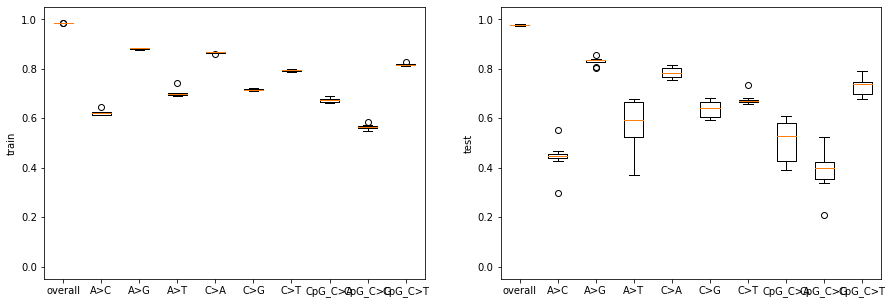

In [11]:
# Model
Model_LRlog2 = LinearRegression(n_jobs=4).fit(Pred_2d, np.log(Eff))
tmp_out = np.exp(Model_LRlog2.predict(Pred_2d))   # Note that we need to use exponential to transform back
print(r2_score(Eff, tmp_out))   # This is the R^2 value
print(r2_score(Eff[Index_class!=8], tmp_out[Index_class!=8]))   # This is the R^2 value for non CpG C>T

# Cross validate
model = LinearRegression(n_jobs=4)
CV_LRlog2 = standard_cv(model, Kfoldobj, Pred_2d, np.log(Eff), Index_class, log=True, record_index=True)
plot_CV_subclass_r2(CV_LRlog2)

How well does this model do in independent testing?

In [12]:
tmp_out = np.exp(Model_LRlog2.predict(Pred_2d))
Result_LRlog2 = standard_traintestresult_df(
    tmp_out, Eff, Eff_test, Index_class, p=4158, display='df')
display(Result_LRlog2)

dump(Model_LRlog2, "data_out/Model_allclass_log.joblib")
dump(CV_LRlog2, "data_out/Results_allclass_log.joblib")
Result_LRlog2.to_csv("data_out/Indtest_allclass_log.csv")

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.608279,26.461844,0.566242,29.194246
A>G,0.879434,8.836779,0.881088,8.729310
A>T,0.689973,21.151731,0.688442,21.251256
C>A,0.862187,1.389350,0.850662,1.421912
C>G,0.709664,1.820258,0.716485,1.800988
C>T,0.791674,1.588564,0.769054,1.652469
CpG_C>A,0.665557,1.109134,0.574010,1.139007
CpG_C>G,0.554150,1.145488,0.464328,1.174798
CpG_C>T,0.819242,1.058984,0.807042,1.062965
overall,0.984580,0.981440,0.984046,0.980797


The adjusted R^2 didn't work out very well due to the number of predictors outnumbering the number of samples...

We have also tried running this with neighboring interactions only, but there is a reduction in R^2 so we didn't show the results here.

Anyways, plot scatterplot:

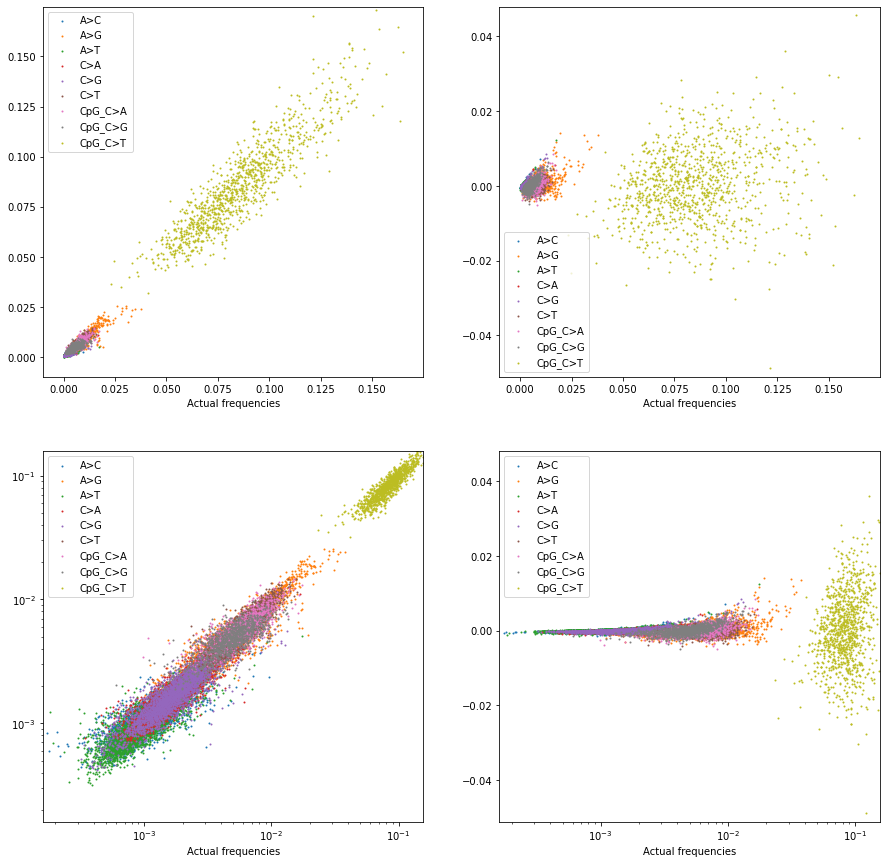

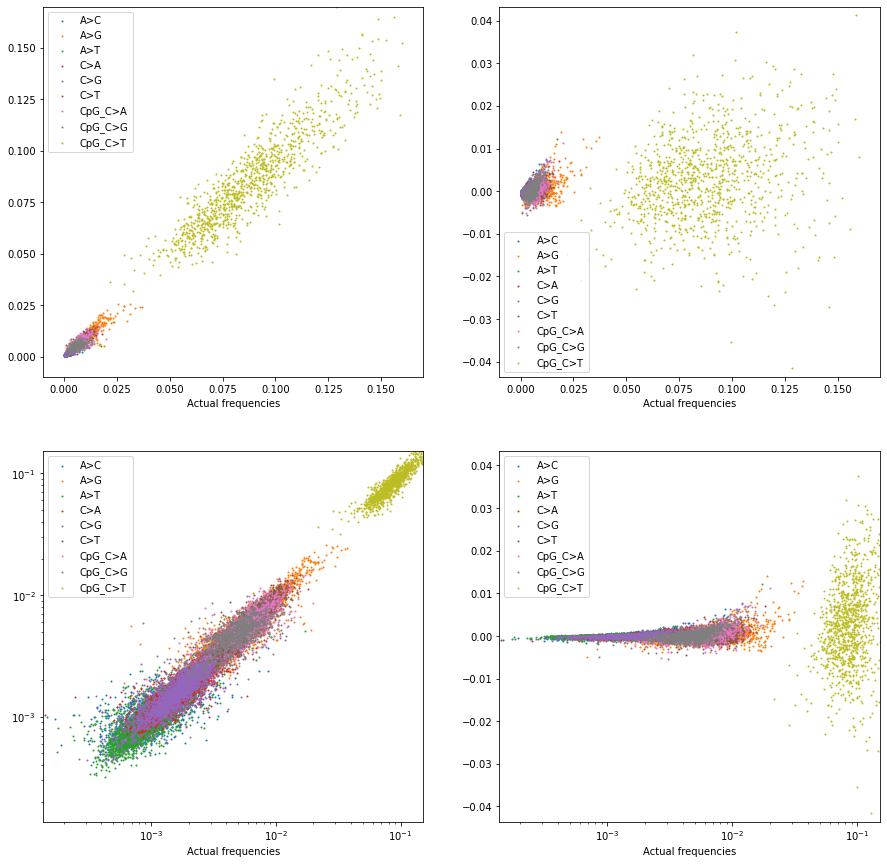

In [13]:
plot_scatter_residual(tmp_out, Eff, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_sup7_model_allclass_train.tiff")
plot_scatter_residual(tmp_out, Eff_test, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_sup7_model_allclass_test.tiff")

Next, use substitution class split. We have shown that using all features would result in overfitting, so we will start with the following.

We have tried AIC but it didn't work out very well. F-regression top k predictors works better, but not as good as L1, so we will only do L1 here.

### Least-squares, L1-regularization

Next, use L1-regularization to select relevant features for each sub model.

We have done this for L1 with all interactions but performance is similar with using neighboring interactions only (with half the predictors), so we will only use neighboring interactions from now. 

In [14]:
alpha_list, Indices_rmL1 = load_L1_indices(
    "data_intermediate/Results_L1_sh1.joblib", "data_intermediate/Models_L1_sh1.joblib", index_class_range=9)

Class 0, Number of predictors: 76
Class 1, Number of predictors: 79
Class 2, Number of predictors: 82
Class 3, Number of predictors: 69
Class 4, Number of predictors: 80
Class 5, Number of predictors: 85
Class 6, Number of predictors: 72
Class 7, Number of predictors: 71
Class 8, Number of predictors: 65


0.9867590157747165
0.8204921399184077


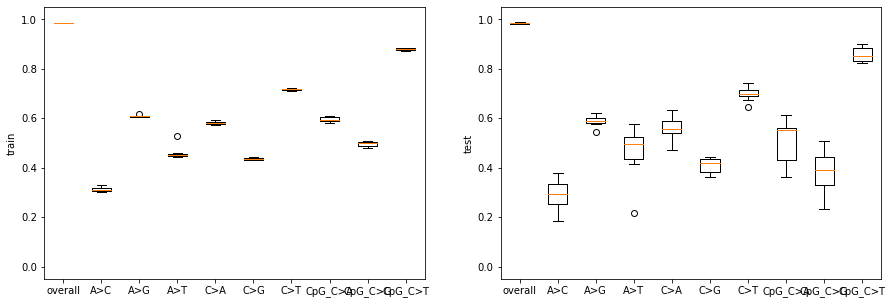

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.309833,0.296781,0.299829,0.286588
A>G,0.607715,0.599998,0.615280,0.607712
A>T,0.457312,0.446223,0.489098,0.478658
C>A,0.580184,0.570535,0.578703,0.569019
C>G,0.434593,0.419470,0.450661,0.435968
C>T,0.716030,0.707946,0.714377,0.706246
CpG_C>A,0.591887,0.560988,0.559250,0.525881
CpG_C>G,0.490682,0.452697,0.440194,0.398444
CpG_C>T,0.878316,0.870060,0.866938,0.857909
overall,0.986759,0.986383,0.986428,0.986042


In [15]:
Model_csplit1rmL1, CV_csplit1rmL1, Result_csplit1rmL1 = standard_l1modelfitting(
    Pred_1d, Eff, Eff_test, Index_class, Indices_rmL1, Kfoldobj, n_jobs=4)

dump(Model_csplit1rmL1, "data_out/Model_sh1.joblib")
dump(CV_csplit1rmL1, "data_out/Results_sh1.joblib")
Result_csplit1rmL1.to_csv("data_out/Indtest_sh1.csv")

In [16]:
alpha_list, Indices_rmL1 = load_L1_indices(
    "data_intermediate/Results_L1_sh2.joblib", "data_intermediate/Models_L1_sh2.joblib", index_class_range=9)
     #"results_lasso/Results_Lassoselect_allclass.joblib", "results_lasso/Models_Lassoselect_allclass.joblib", index_class_range=9)

Class 0, Number of predictors: 418
Class 1, Number of predictors: 822
Class 2, Number of predictors: 367
Class 3, Number of predictors: 805
Class 4, Number of predictors: 840
Class 5, Number of predictors: 523
Class 6, Number of predictors: 110
Class 7, Number of predictors: 135
Class 8, Number of predictors: 128


0.9938046088747585
0.9434849406175337


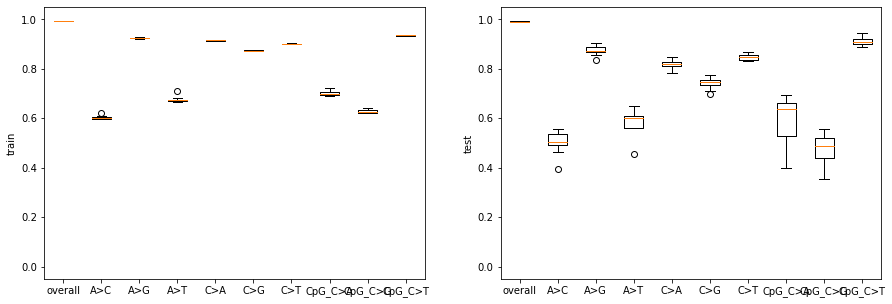

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.597699,0.551966,0.538520,0.486059
A>G,0.922733,0.903328,0.920418,0.900431
A>T,0.670343,0.637890,0.672069,0.639786
C>A,0.910672,0.878938,0.883743,0.842442
C>G,0.867692,0.817876,0.836551,0.775011
C>T,0.898180,0.877280,0.870506,0.843926
CpG_C>A,0.695228,0.658508,0.631292,0.586870
CpG_C>G,0.620062,0.562301,0.532281,0.461175
CpG_C>T,0.934675,0.925332,0.918123,0.906413
overall,0.993805,0.992547,0.992641,0.991147


In [17]:
Model_csplit2rmL1, CV_csplit2rmL1, Result_csplit2rmL1 = standard_l1modelfitting(
    Pred_2d, Eff, Eff_test, Index_class, Indices_rmL1, Kfoldobj, n_jobs=4)

dump(Model_csplit2rmL1, "data_out/Model_sh2.joblib")
dump(CV_csplit2rmL1, "data_out/Results_sh2.joblib")
Result_csplit2rmL1.to_csv("data_out/Indtest_sh2.csv")

### L1 regularization, neighbors interactions only

Use only neighboring interactions instead. We still need to run this on a cloud:

Get the alpha values:

In [7]:
alpha_list, Indices_rmL1neibr = load_L1_indices(
    #"results_L1neighbor/Results_Lassoselect_allclass.joblib", "results_L1neighbor/Models_Lassoselect_allclass.joblib")
     "data_intermediate/Results_L1_sh2neibr.joblib", "data_intermediate/Models_L1_sh2neibr.joblib", index_class_range=9)

Class 0, Number of predictors: 629
Class 1, Number of predictors: 889
Class 2, Number of predictors: 501
Class 3, Number of predictors: 616
Class 4, Number of predictors: 770
Class 5, Number of predictors: 527
Class 6, Number of predictors: 123
Class 7, Number of predictors: 126
Class 8, Number of predictors: 175


/home/zianl/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator Lasso from version 0.23.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0.9944731889669096
0.9440255774648938


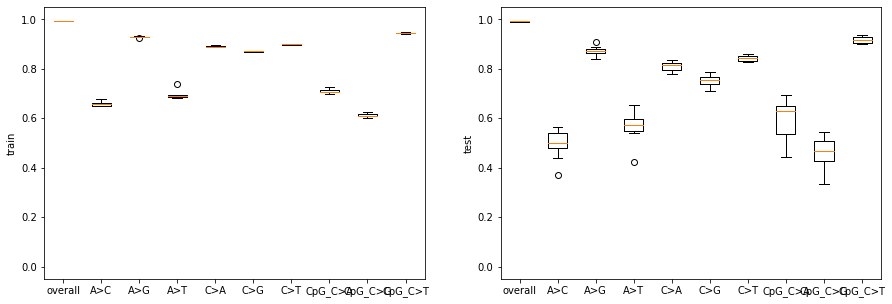

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.648458,0.584661,0.578731,0.502281
A>G,0.926287,0.905847,0.922207,0.900635
A>T,0.686432,0.642721,0.672824,0.627216
C>A,0.886260,0.857721,0.868189,0.835116
C>G,0.864279,0.818862,0.833801,0.778184
C>T,0.896343,0.874869,0.869824,0.842857
CpG_C>A,0.704173,0.663743,0.634640,0.584708
CpG_C>G,0.604332,0.548753,0.517474,0.449695
CpG_C>T,0.943422,0.931746,0.925088,0.909628
overall,0.994473,0.993282,0.993148,0.991672


In [8]:
Model_csplit2rmL1_neibr, CV_csplit2rmL1_neibr, Result_csplit2rmL1_neibr = standard_l1modelfitting(
    Pred_2dneibr, Eff, Eff_test, Index_class, Indices_rmL1neibr, Kfoldobj, n_jobs=4)

dump(Model_csplit2rmL1_neibr, "data_out/Model_sh2neibr.joblib")
dump(CV_csplit2rmL1_neibr, "data_out/Results_sh2neibr.joblib")
Result_csplit2rmL1_neibr.to_csv("data_out/Indtest_sh2neibr.csv")

Plot scatterplot:

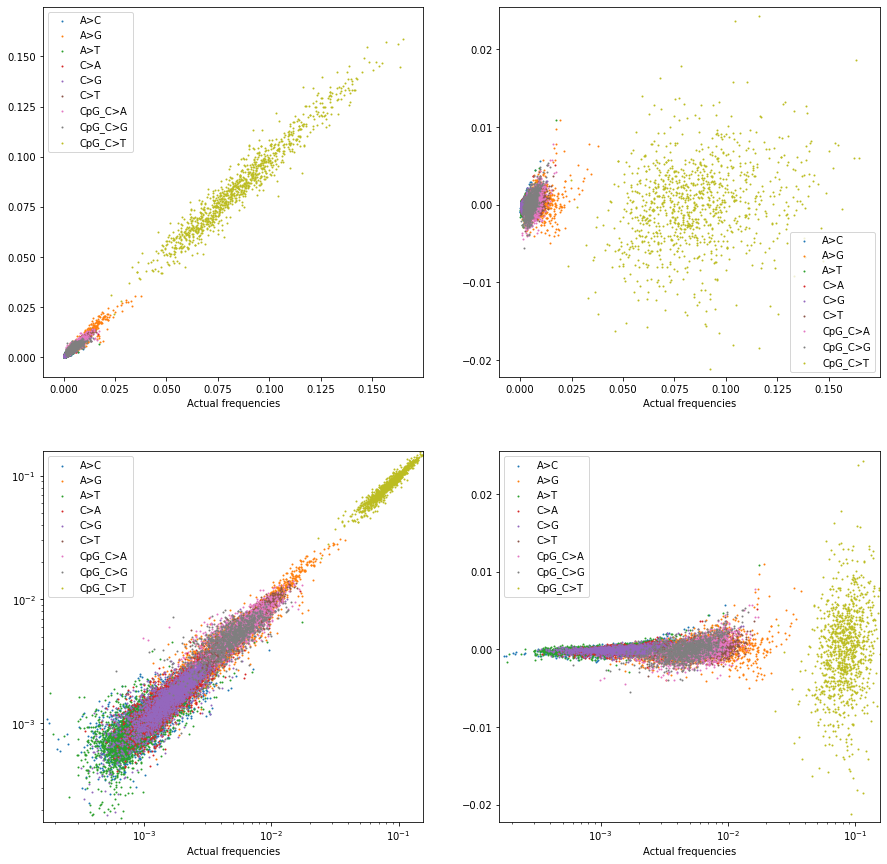

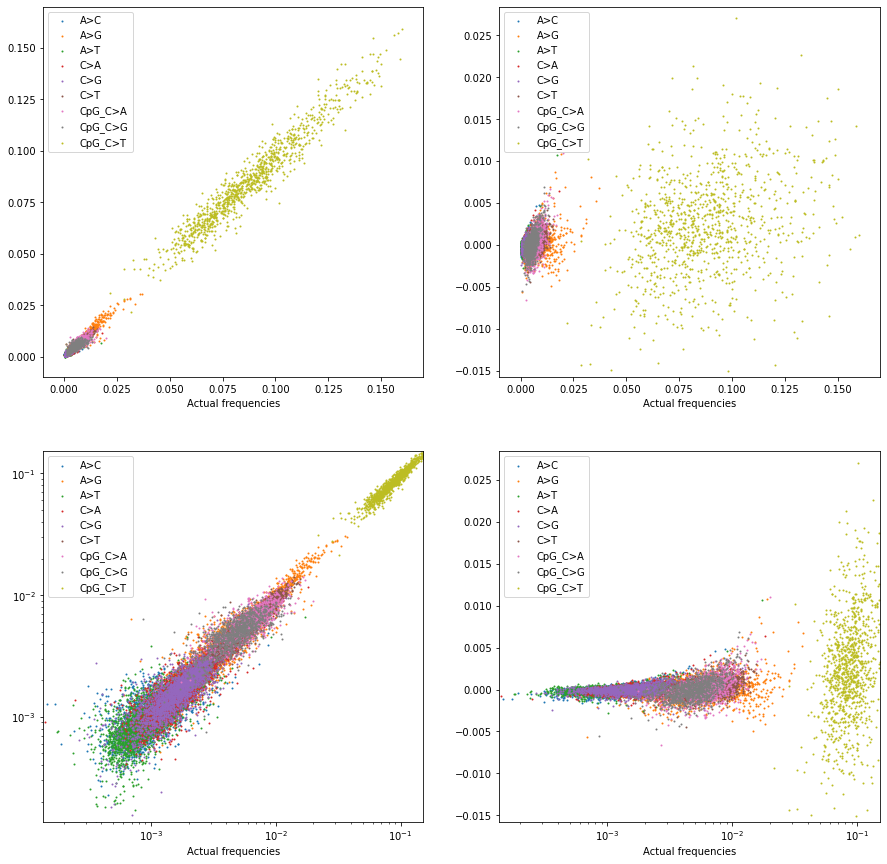

In [10]:
tmp_out = Model_csplit2rmL1_neibr.predict(Pred_2dneibr, Index_class)

plot_scatter_residual(tmp_out, Eff, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_sup6_model_sh2neibr_train.tiff")
plot_scatter_residual(tmp_out, Eff_test, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_sup6_model_sh2neibr_test.tiff")

## Sequence context models

Also try out sequence context models. 

### Varun's model

Import model coefficients directly from Varun's model:

In [20]:
Coefs_Varun = pd.read_excel("./data_input/41588_2016_BFng3511_MOESM210_ESM.xlsx", sheet_name="Supplementary Table 6a", 
                           header=1, index_col=0, usecols="K:R")
Coefs_Varun_cpg = pd.read_excel("./data_input/41588_2016_BFng3511_MOESM210_ESM.xlsx", sheet_name="Supplementary Table 6b", 
                               header=1, index_col=0, usecols="H:L")
# See how the output is like
display(Coefs_Varun[0:10])

Index_Varun = list(Coefs_Varun.index)
Index_Varun = np.array([re.sub('-', '', item) for item in Index_Varun])
Index_Varun_cpg = list(Coefs_Varun_cpg.index)
Index_Varun_cpg = np.array([re.sub('-', '', item) for item in Index_Varun_cpg])
print(Index_Varun[0:10])

,ORDER.1,BETA_AtoC.1,BETA_AtoG.1,BETA_AtoT.1,BETA_CtoA.1,BETA_CtoG.1,BETA_CtoT.1
SEQ_CONTEXT.1,,,,,,,
Intercept,0,0.001270,0.002750,0.000737,0.004180,0.002480,0.005490
C__-___,1,-0.000363,-0.000686,-0.000142,0.000116,-0.000058,0.000088
G__-___,1,-0.000515,0.000109,-0.000108,0.000292,-0.000163,-0.000182
T__-___,1,-0.000381,0.000084,-0.000090,-0.000384,-0.000154,0.000050
_C_-___,1,-0.000059,0.000950,-0.000082,-0.000822,0.000404,0.001170
_G_-___,1,-0.000065,0.000705,-0.000173,-0.000394,-0.000235,0.000380
_T_-___,1,0.000227,0.000327,0.000175,-0.000343,-0.000134,0.003600
__C-___,1,0.000155,0.000648,0.000240,-0.000481,0.000023,-0.001450
__G-___,1,-0.000178,0.000623,0.000093,-0.000383,-0.000400,-0.001260


['Intercept' 'C_____' 'G_____' 'T_____' '_C____' '_G____' '_T____'
 '__C___' '__G___' '__T___']


0.9931632320052356
0.9306113585424256


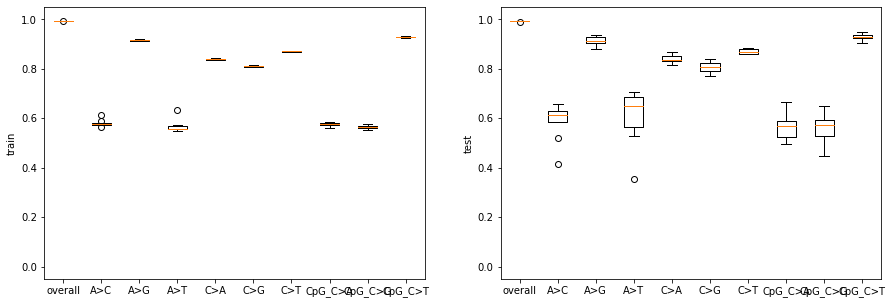

In [21]:
list_coefs_import, list_intc_import = [], []
for select in range(9):
    # Create coefficients
    if select <= 5:
        Coefs_V = np.array(Coefs_Varun.iloc[:, select+1])
        Index_V = deepcopy(Index_Varun)
    else:
        Coefs_V = np.array(Coefs_Varun_cpg.iloc[:, select-5])
        Index_V = deepcopy(Index_Varun_cpg)
    Index_V = Index_V[~np.isnan(Coefs_V)]
    Coefs_V = Coefs_V[~np.isnan(Coefs_V)]
    # Assign model parameters
    list_coefs_import.append(np.zeros(shape=(np.shape(Pred_sc_4d)[1], )))
    list_coefs_import[select][np.isin(Labels_sc_4d, Index_V)] = Coefs_V[1::]
    list_intc_import.append(Coefs_V[0])

Model_Varun = linreg_bysubclassall_assign_index(assign_coefs=list_coefs_import, assign_intc=list_intc_import, n_jobs=4)
Model_Varun.fit(Pred_sc_4d, Eff)
tmp_out = Model_Varun.predict(Pred_sc_4d, Index_class_sc)
print(r2_score(Eff, tmp_out))   # This is the R^2 value
print(r2_score(Eff[Index_class_sc!=8], tmp_out[Index_class_sc!=8]))   # This is the R^2 value for non CpG C>T

# Cross validate
model = linreg_bysubclassall_assign_index(assign_coefs=list_coefs_import, assign_intc=list_intc_import, n_jobs=4)
CV_Varunmod = standard_cv(model, Kfoldobj, Pred_sc_4d, Eff, Index_class_sc, use_index=True, record_index=True)
plot_CV_subclass_r2(CV_Varunmod)

Test data:

In [22]:
tmp_out = Model_Varun.predict(Pred_sc_4d, Index_class_sc)
p_size = [np.sum(Model_Varun.model[select].coef_ != 0) for select in range(9)]
Result_Varunmod = standard_traintestresult_df(
    tmp_out, Eff, Eff_test, Index_class_sc, p=p_size, display='df')
display(Result_Varunmod)

dump(Model_Varun, "data_out/Model_sc4Varun.joblib")
dump(CV_Varunmod, "data_out/Results_sc4Varun.joblib")
Result_Varunmod.to_csv("data_out/Indtest_sc4Varun.csv")

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.580066,0.550893,0.580254,0.551095
A>G,0.915877,0.907620,0.919987,0.912133
A>T,0.566845,0.544954,0.605163,0.585208
C>A,0.839504,0.823276,0.840336,0.824193
C>G,0.810782,0.792690,0.819134,0.801841
C>T,0.870864,0.859220,0.875378,0.864141
CpG_C>A,0.576305,0.565255,0.553423,0.541777
CpG_C>G,0.564764,0.520209,0.530545,0.482486
CpG_C>T,0.930057,0.922813,0.932358,0.925353
overall,0.993163,0.992607,0.993584,0.993062


### L1 selection with sequence context only

Do L1 selection on 2nd to 4th degree transform of sequence context:

Sequence context: 2 degree
Class 0, Number of predictors: 121
Class 1, Number of predictors: 125
Class 2, Number of predictors: 107
Class 3, Number of predictors: 117
Class 4, Number of predictors: 121
Class 5, Number of predictors: 131
Class 6, Number of predictors: 81
Class 7, Number of predictors: 79
Class 8, Number of predictors: 113


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9911686272104046
0.869922877611137


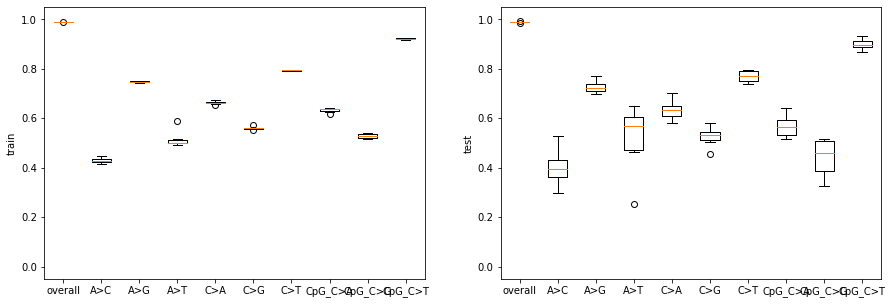

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.426719,0.409264,0.413254,0.395388
A>G,0.746094,0.738099,0.755598,0.747903
A>T,0.510145,0.497002,0.543133,0.530875
C>A,0.661170,0.647750,0.666181,0.652959
C>G,0.557901,0.539767,0.571532,0.553957
C>T,0.791988,0.782719,0.784710,0.775118
CpG_C>A,0.632004,0.600361,0.587290,0.551802
CpG_C>G,0.521883,0.481871,0.484295,0.441137
CpG_C>T,0.922001,0.912315,0.907726,0.896268
overall,0.991169,0.990796,0.990474,0.990072


Sequence context: 3 degree
Class 0, Number of predictors: 278
Class 1, Number of predictors: 419
Class 2, Number of predictors: 245
Class 3, Number of predictors: 307
Class 4, Number of predictors: 290
Class 5, Number of predictors: 348
Class 6, Number of predictors: 180
Class 7, Number of predictors: 175
Class 8, Number of predictors: 314


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9948984073268107
0.9315995372802914


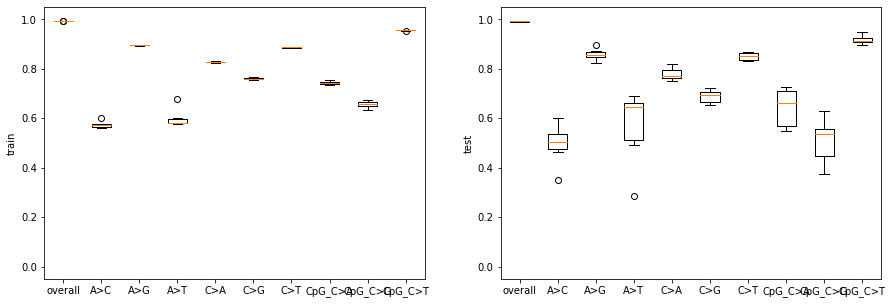

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.568934,0.537539,0.527979,0.493601
A>G,0.893989,0.881905,0.894514,0.882490
A>T,0.592268,0.566322,0.596595,0.570924
C>A,0.825176,0.805758,0.816076,0.795647
C>G,0.755344,0.729831,0.757107,0.731778
C>T,0.884995,0.870298,0.869194,0.852477
CpG_C>A,0.738058,0.682127,0.607113,0.523222
CpG_C>G,0.656114,0.585147,0.535023,0.439067
CpG_C>T,0.952884,0.932017,0.927502,0.895394
overall,0.994898,0.994306,0.993065,0.992260


Sequence context: 4 degree
Class 0, Number of predictors: 368
Class 1, Number of predictors: 578
Class 2, Number of predictors: 213
Class 3, Number of predictors: 685
Class 4, Number of predictors: 521
Class 5, Number of predictors: 583
Class 6, Number of predictors: 251
Class 7, Number of predictors: 285
Class 8, Number of predictors: 500


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9961767179548515
0.9515687651397196


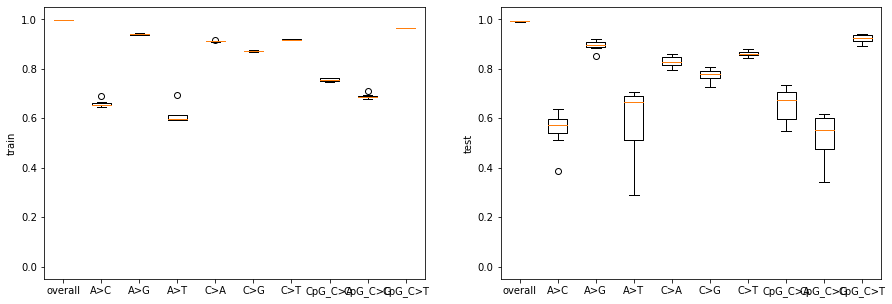

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.653274,0.619039,0.581512,0.540191
A>G,0.937805,0.927583,0.929313,0.917695
A>T,0.606204,0.584597,0.591188,0.568757
C>A,0.907601,0.881074,0.876613,0.841190
C>G,0.867100,0.839947,0.841049,0.808573
C>T,0.915258,0.895400,0.877599,0.848918
CpG_C>A,0.753092,0.672815,0.610416,0.483751
CpG_C>G,0.689576,0.569696,0.526647,0.343849
CpG_C>T,0.963826,0.929242,0.931482,0.865978
overall,0.996177,0.995437,0.993644,0.992415


In [23]:
pred_all = [None, None, Pred_sc_2d, Pred_sc_3d, Pred_sc_4d]

for i in range(2, 5):
    dsc = str(i)
    print("Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1 = load_L1_indices(
    "data_intermediate/Results_L1_sc"+dsc+".joblib", "data_intermediate/Models_L1_sc"+dsc+".joblib")

    Model, CV_L1, Result = standard_l1modelfitting(
    pred_all[i], Eff, Eff_test, Index_class, Indices_rmL1, Kfoldobj, n_jobs=4)

    dump(Model, "data_out/Model_sc"+dsc+".joblib")
    dump(CV_L1, "data_out/Results_sc"+dsc+".joblib")
    Result.to_csv("data_out/Indtest_sc"+dsc+".csv")

Same as above, but with neighboring interactions only:

Sequence context: 2 degree
Class 0, Number of predictors: 48
Class 1, Number of predictors: 55
Class 2, Number of predictors: 60
Class 3, Number of predictors: 52
Class 4, Number of predictors: 48
Class 5, Number of predictors: 49
Class 6, Number of predictors: 36
Class 7, Number of predictors: 41
Class 8, Number of predictors: 45


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9857315312708516
0.8278373196040594


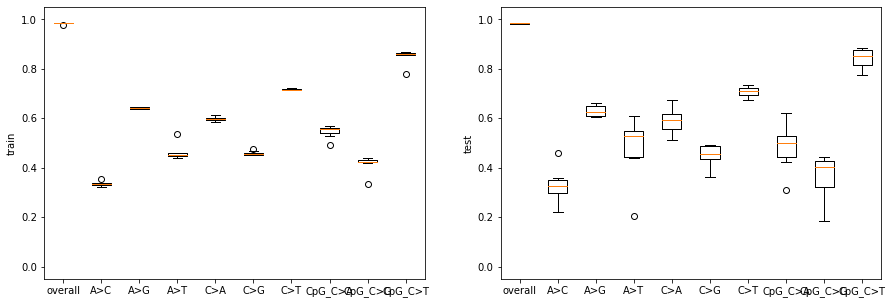

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.334714,0.326823,0.326221,0.318230
A>G,0.640797,0.635906,0.649499,0.644727
A>T,0.459333,0.451294,0.495868,0.488372
C>A,0.597710,0.590781,0.607692,0.600935
C>G,0.457661,0.449050,0.475512,0.467184
C>T,0.715998,0.711393,0.718508,0.713944
CpG_C>A,0.557412,0.541269,0.526544,0.509275
CpG_C>G,0.425060,0.401056,0.396678,0.371488
CpG_C>T,0.862377,0.856045,0.850136,0.843240
overall,0.985732,0.985475,0.985396,0.985134


Sequence context: 3 degree
Class 0, Number of predictors: 119
Class 1, Number of predictors: 142
Class 2, Number of predictors: 129
Class 3, Number of predictors: 106
Class 4, Number of predictors: 106
Class 5, Number of predictors: 118
Class 6, Number of predictors: 71
Class 7, Number of predictors: 71
Class 8, Number of predictors: 90


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9894424979363942
0.8673045897412942


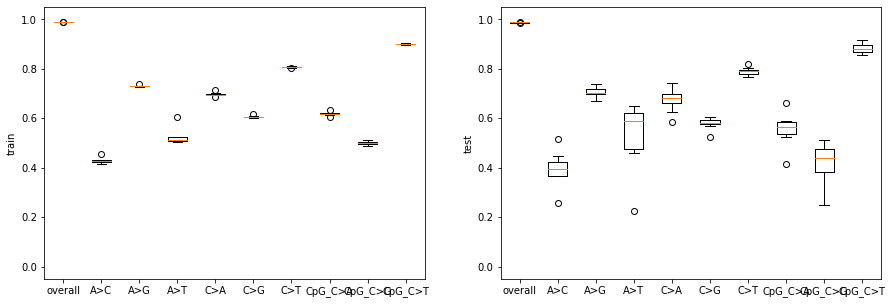

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.427025,0.409877,0.407497,0.389764
A>G,0.729320,0.719597,0.739321,0.729957
A>T,0.520594,0.505000,0.550692,0.536077
C>A,0.696137,0.685274,0.701824,0.691164
C>G,0.604991,0.590869,0.618433,0.604792
C>T,0.805945,0.798191,0.801224,0.793281
CpG_C>A,0.615573,0.586902,0.571355,0.539386
CpG_C>G,0.496727,0.459193,0.457568,0.417113
CpG_C>T,0.899792,0.890125,0.888878,0.878159
overall,0.989442,0.989017,0.989051,0.988610


Sequence context: 4 degree
Class 0, Number of predictors: 163
Class 1, Number of predictors: 164
Class 2, Number of predictors: 181
Class 3, Number of predictors: 225
Class 4, Number of predictors: 154
Class 5, Number of predictors: 178
Class 6, Number of predictors: 108
Class 7, Number of predictors: 107
Class 8, Number of predictors: 155


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9915101807293831
0.8796703026898356


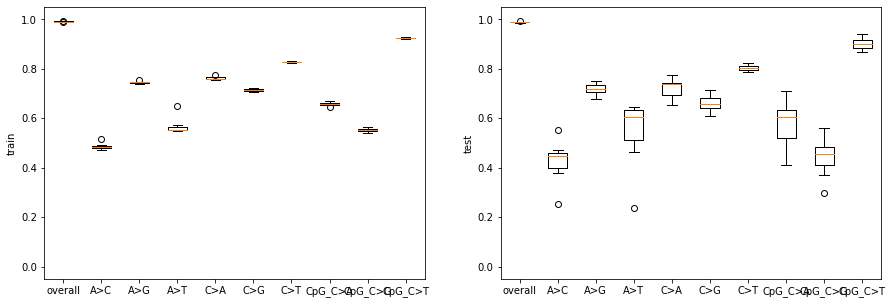

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.482667,0.461222,0.446439,0.423491
A>G,0.743922,0.733238,0.750784,0.740387
A>T,0.562553,0.542324,0.572760,0.553003
C>A,0.760988,0.742093,0.765171,0.746606
C>G,0.711299,0.696058,0.717907,0.703014
C>T,0.826944,0.816296,0.818741,0.807588
CpG_C>A,0.656902,0.616405,0.594880,0.547063
CpG_C>G,0.548841,0.496140,0.497089,0.438343
CpG_C>T,0.923577,0.909930,0.912177,0.896495
overall,0.991510,0.990984,0.990966,0.990406


In [24]:
pred_all = [None, None, Pred_sc_2dneibr, Pred_sc_3dneibr, Pred_sc_4dneibr]

for i in range(2, 5):
    dsc = str(i)
    print("Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_neibr = load_L1_indices(
    "data_intermediate/Results_L1_sc"+dsc+"neibr.joblib", "data_intermediate/Models_L1_sc"+dsc+"neibr.joblib")

    Model, CV_L1, Result = standard_l1modelfitting(
    pred_all[i], Eff, Eff_test, Index_class, Indices_rmL1_neibr, Kfoldobj, n_jobs=4)

    dump(Model, "data_out/Model_sc"+dsc+"neibr.joblib")
    dump(CV_L1, "data_out/Results_sc"+dsc+"neibr.joblib")
    Result.to_csv("data_out/Indtest_sc"+dsc+"neibr.csv")

As shown, the neighboring only interactions appear to have lower efficacy compared to all sequence context interactions.

## Combination models

Mix shape features and sequence context to obtain more accurate predictions.

### Binning lower degree sequence context to lower degree shapes

What if we use lower dimension shapes and sequences?

Some basic analysis suggests that 2nd-3rd degree sequence context + 1st degree shapes is the sweet spot; we can increase it to 4th degree sequence context + 1st degree shape or any degree sequence context + 2nd degree shape, but that would start to lead to overfitting (although it also leads to better models). 

We will approach it by sequentially building more and more complex models and use L1-regularization on them. 

Integrate 1st degree shape features with 1st to 3rd degree sequence context sequentially by applying L1 regularization. 

### Binned predictors, optimal models from L1 selections

Do this as a sequential model-building exercise. 

#### 1st degree shape + 1-4 degree sequence context

Shape 1 degree; Sequence context: 1 degree
Class 0, Number of predictors: 76
Class 1, Number of predictors: 95
Class 2, Number of predictors: 92
Class 3, Number of predictors: 83
Class 4, Number of predictors: 98
Class 5, Number of predictors: 105
Class 6, Number of predictors: 78
Class 7, Number of predictors: 67
Class 8, Number of predictors: 92


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9888568601005785
0.837526100236741


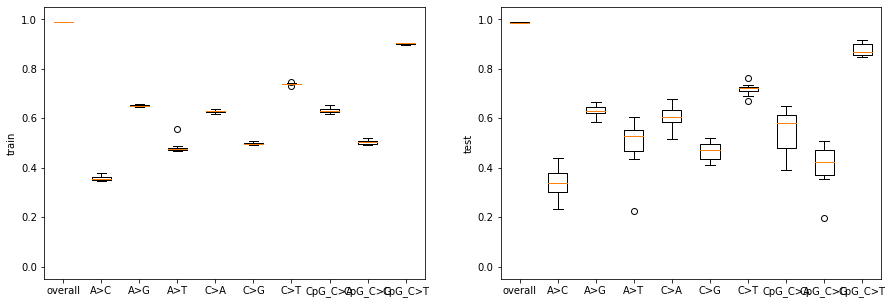

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.355153,0.342959,0.341260,0.328804
A>G,0.650088,0.641778,0.658699,0.650593
A>T,0.482227,0.470327,0.514254,0.503091
C>A,0.626443,0.616066,0.624594,0.614166
C>G,0.496007,0.479394,0.512664,0.496600
C>T,0.737985,0.728709,0.735687,0.726330
CpG_C>A,0.628761,0.598119,0.578570,0.543786
CpG_C>G,0.499291,0.464200,0.448816,0.410187
CpG_C>T,0.901078,0.891303,0.889348,0.878413
overall,0.988857,0.988489,0.988423,0.988040


Shape 1 degree; Sequence context: 2 degree
Class 0, Number of predictors: 198
Class 1, Number of predictors: 220
Class 2, Number of predictors: 135
Class 3, Number of predictors: 214
Class 4, Number of predictors: 201
Class 5, Number of predictors: 206
Class 6, Number of predictors: 69
Class 7, Number of predictors: 76
Class 8, Number of predictors: 135


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9923334759036522
0.8875690790485792


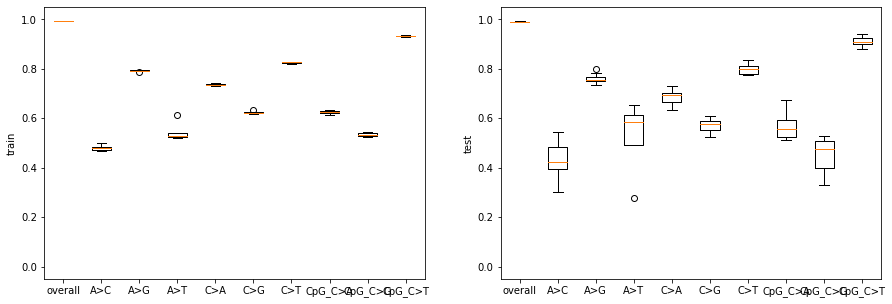

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.475929,0.449301,0.455424,0.427755
A>G,0.790398,0.778498,0.800481,0.789154
A>T,0.536283,0.520475,0.569259,0.554574
C>A,0.732724,0.712704,0.730663,0.710488
C>G,0.618944,0.592256,0.627984,0.601930
C>T,0.825249,0.812684,0.816539,0.803348
CpG_C>A,0.624187,0.597005,0.574152,0.543351
CpG_C>G,0.531282,0.493665,0.490520,0.449632
CpG_C>T,0.932139,0.921823,0.916414,0.903707
overall,0.992333,0.991851,0.991479,0.990943


Shape 1 degree; Sequence context: 3 degree
Class 0, Number of predictors: 278
Class 1, Number of predictors: 409
Class 2, Number of predictors: 246
Class 3, Number of predictors: 506
Class 4, Number of predictors: 290
Class 5, Number of predictors: 352
Class 6, Number of predictors: 184
Class 7, Number of predictors: 225
Class 8, Number of predictors: 316


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9951679727108452
0.9333022679864588


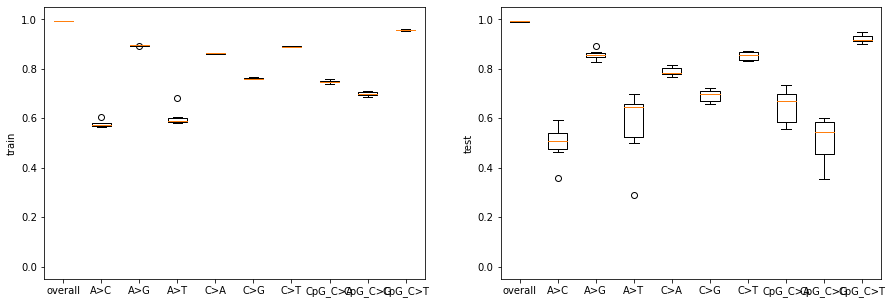

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.572164,0.541004,0.532820,0.498794
A>G,0.892448,0.880513,0.893368,0.881536
A>T,0.596943,0.571182,0.603209,0.577849
C>A,0.858301,0.830348,0.845032,0.814462
C>G,0.757272,0.731961,0.758253,0.733044
C>T,0.886914,0.872274,0.871354,0.854699
CpG_C>A,0.745102,0.689201,0.618078,0.534319
CpG_C>G,0.687284,0.599113,0.528789,0.395929
CpG_C>T,0.955957,0.936272,0.930460,0.899378
overall,0.995168,0.994545,0.993304,0.992441


Shape 1 degree; Sequence context: 4 degree
Class 0, Number of predictors: 450
Class 1, Number of predictors: 628
Class 2, Number of predictors: 275
Class 3, Number of predictors: 603
Class 4, Number of predictors: 517
Class 5, Number of predictors: 584
Class 6, Number of predictors: 259
Class 7, Number of predictors: 285
Class 8, Number of predictors: 516


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9963314321575026
0.9527705810694679


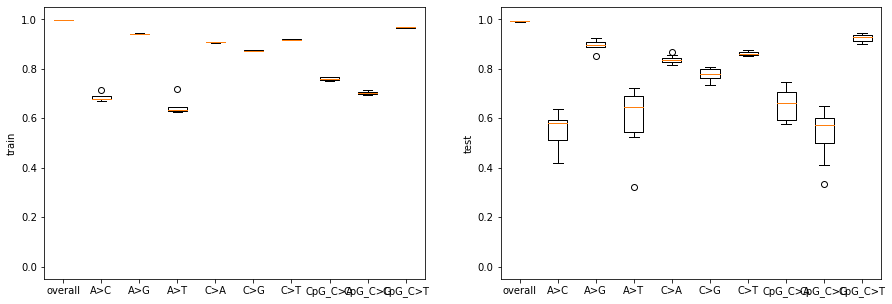

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.677261,0.637417,0.586199,0.535113
A>G,0.939826,0.928926,0.930415,0.917811
A>T,0.638922,0.612928,0.610173,0.582110
C>A,0.904129,0.880705,0.877821,0.847969
C>G,0.868681,0.842099,0.842336,0.810420
C>T,0.915523,0.895686,0.877930,0.849266
CpG_C>A,0.754992,0.671933,0.609131,0.476624
CpG_C>G,0.695658,0.578127,0.526087,0.343072
CpG_C>T,0.965521,0.930430,0.932331,0.863460
overall,0.996331,0.995593,0.993718,0.992454


In [25]:
pred_binned_all = [None, 
    np.concatenate((Pred_1d, Pred_sc_1d), axis=1), np.concatenate((Pred_1d, Pred_sc_2d), axis=1), 
    np.concatenate((Pred_1d, Pred_sc_3d), axis=1), np.concatenate((Pred_1d, Pred_sc_4d), axis=1)
]

for i in range(1, 5):
    dsc = str(i)
    print("Shape 1 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin = load_L1_indices(
        "data_intermediate/Results_L1_sh1_sc"+dsc+".joblib", "data_intermediate/Models_L1_sh1_sc"+dsc+".joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i], Eff, Eff_test, Index_class, Indices_rmL1_bin, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh1_sc"+dsc+".joblib")
    dump(CV_L1, "data_out/Results_sh1_sc"+dsc+".joblib")
    Result.to_csv("data_out/Indtest_sh1_sc"+dsc+".csv")

These conclude the performances of the 1st degree shape, nth degree sc models. 

#### 2nd degree shape, 1-4 degree sequence context

Shape 2 degree; Sequence context: 1 degree
Class 0, Number of predictors: 623
Class 1, Number of predictors: 840
Class 2, Number of predictors: 301
Class 3, Number of predictors: 709
Class 4, Number of predictors: 896
Class 5, Number of predictors: 624
Class 6, Number of predictors: 110
Class 7, Number of predictors: 93
Class 8, Number of predictors: 185
0.9946384804302345
0.9430249580125458


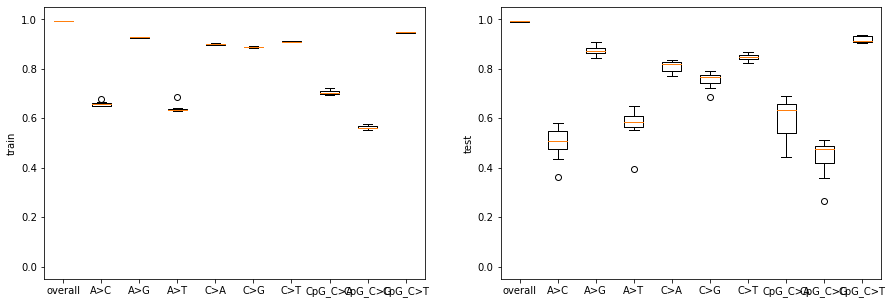

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.649310,0.586384,0.579134,0.503616
A>G,0.924084,0.904493,0.920586,0.900092
A>T,0.634905,0.605940,0.650158,0.622403
C>A,0.896176,0.865011,0.872901,0.834750
C>G,0.881823,0.833139,0.843934,0.779641
C>T,0.907683,0.884142,0.872579,0.840086
CpG_C>A,0.698754,0.662459,0.626211,0.581176
CpG_C>G,0.557023,0.512725,0.480210,0.428231
CpG_C>T,0.945931,0.933994,0.926038,0.909710
overall,0.994638,0.993475,0.993192,0.991715


Shape 2 degree; Sequence context: 2 degree
Class 0, Number of predictors: 524
Class 1, Number of predictors: 673
Class 2, Number of predictors: 273
Class 3, Number of predictors: 666
Class 4, Number of predictors: 655
Class 5, Number of predictors: 524
Class 6, Number of predictors: 101
Class 7, Number of predictors: 74
Class 8, Number of predictors: 175
0.9943601281661438
0.9382535455670626


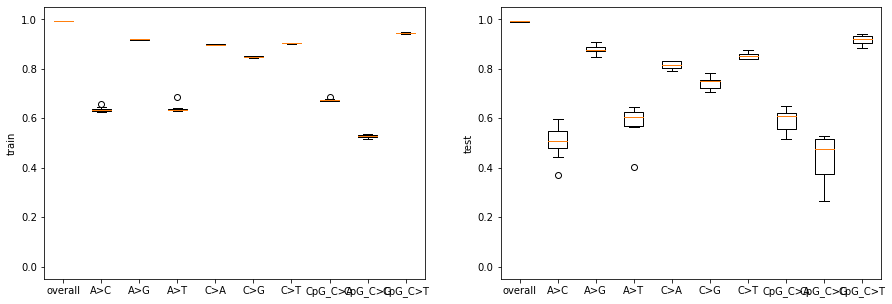

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.628268,0.573721,0.568701,0.505413
A>G,0.917537,0.901319,0.915870,0.899324
A>T,0.635332,0.609284,0.653108,0.628329
C>A,0.893558,0.864082,0.872418,0.837088
C>G,0.843522,0.801099,0.824286,0.776648
C>T,0.901042,0.880683,0.874477,0.848653
CpG_C>A,0.663348,0.626469,0.602914,0.559415
CpG_C>G,0.531491,0.494958,0.492968,0.453431
CpG_C>T,0.943677,0.932054,0.926926,0.911846
overall,0.994360,0.993372,0.993213,0.992023


Shape 2 degree; Sequence context: 3 degree
Class 0, Number of predictors: 295
Class 1, Number of predictors: 850
Class 2, Number of predictors: 197
Class 3, Number of predictors: 656
Class 4, Number of predictors: 344
Class 5, Number of predictors: 407
Class 6, Number of predictors: 154
Class 7, Number of predictors: 167
Class 8, Number of predictors: 312


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.995444054225345
0.9432292255298282


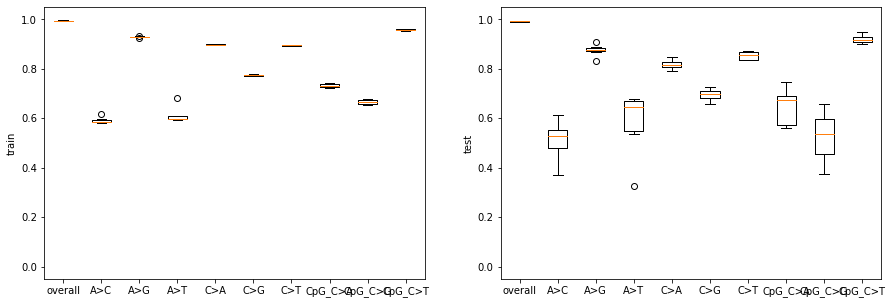

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.585846,0.553695,0.543395,0.507948
A>G,0.927085,0.907986,0.923850,0.903903
A>T,0.605188,0.585235,0.615676,0.596253
C>A,0.893377,0.864415,0.874875,0.840886
C>G,0.769698,0.740647,0.768128,0.738879
C>T,0.893491,0.877219,0.875983,0.857036
CpG_C>A,0.729806,0.681923,0.614639,0.546347
CpG_C>G,0.660036,0.593711,0.530183,0.438524
CpG_C>T,0.956606,0.937564,0.930121,0.899457
overall,0.995444,0.994717,0.993486,0.992446


Shape 2 degree; Sequence context: 4 degree
Class 0, Number of predictors: 373
Class 1, Number of predictors: 643
Class 2, Number of predictors: 286
Class 3, Number of predictors: 617
Class 4, Number of predictors: 550
Class 5, Number of predictors: 600
Class 6, Number of predictors: 207
Class 7, Number of predictors: 233
Class 8, Number of predictors: 527
0.9965973921612629
0.9525510954764077


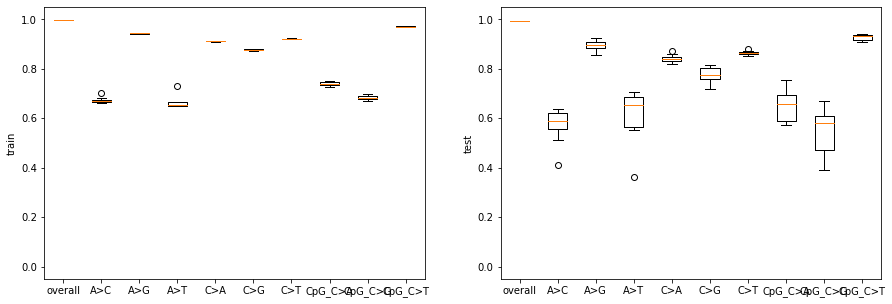

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.667510,0.634189,0.591645,0.550722
A>G,0.940950,0.929951,0.931424,0.918650
A>T,0.658313,0.632658,0.631481,0.603811
C>A,0.907886,0.884726,0.882470,0.852920
C>G,0.872036,0.844119,0.843659,0.809551
C>T,0.918519,0.898734,0.882117,0.853493
CpG_C>A,0.736823,0.670061,0.610559,0.511767
CpG_C>G,0.676010,0.580454,0.523936,0.383527
CpG_C>T,0.969133,0.936337,0.934214,0.864316
overall,0.996597,0.995929,0.993876,0.992673


In [90]:
pred_binned_all = [
    np.concatenate((Pred_2dneibr, Pred_sc_1d), axis=1), np.concatenate((Pred_2dneibr, Pred_sc_2d), axis=1), 
    np.concatenate((Pred_2dneibr, Pred_sc_3d), axis=1), np.concatenate((Pred_2dneibr, Pred_sc_4d), axis=1)
]

# Note:
# Currently, load "results_binned/Models_bin_n2_allclass.joblib" and "results_binned/Results_bin_n2_allclass.joblib"

for i in range(1, 5):
    dsc = str(i)
    print("Shape 2 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin = load_L1_indices(
        "data_intermediate/Results_L1_sh2neibr_sc"+dsc+".joblib", "data_intermediate/Models_L1_sh2neibr_sc"+dsc+".joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i-1], Eff, Eff_test, Index_class, Indices_rmL1_bin, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh2neibr_sc"+dsc+".joblib")
    dump(CV_L1, "data_out/Results_sh2neibr_sc"+dsc+".joblib")
    Result.to_csv("data_out/Indtest_sh2neibr_sc"+dsc+".csv")

### Neighboring only interactions in seqcon?

What if we run neighboring interactions only with seqcon combined with neighboring only shapes?

#### 1st order shape + 2nd to 4th degree sequence context (neighbors only)

Use 1st order shape features plus different sequence context predictors.

Shape 1 degree; Sequence context: 2 degree
Class 0, Number of predictors: 114
Class 1, Number of predictors: 128
Class 2, Number of predictors: 128
Class 3, Number of predictors: 136
Class 4, Number of predictors: 132
Class 5, Number of predictors: 41
Class 6, Number of predictors: 43
Class 7, Number of predictors: 69
Class 8, Number of predictors: 108
0.9908033530237688
0.854359035030396


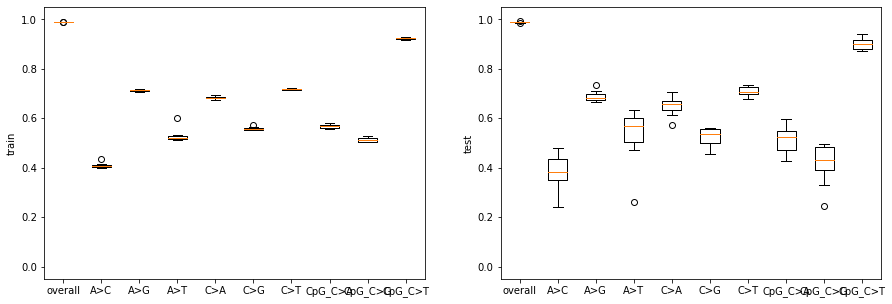

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.406553,0.389559,0.386242,0.368667
A>G,0.711991,0.702699,0.720573,0.711557
A>T,0.526355,0.511072,0.555155,0.540801
C>A,0.681077,0.666299,0.683429,0.668760
C>G,0.556230,0.536299,0.569222,0.549874
C>T,0.716180,0.712339,0.718338,0.714527
CpG_C>A,0.568499,0.549566,0.538631,0.518387
CpG_C>G,0.508900,0.473380,0.455661,0.416290
CpG_C>T,0.921884,0.912664,0.909344,0.898644
overall,0.990803,0.990454,0.990260,0.989890


Shape 1 degree; Sequence context: 3 degree
Class 0, Number of predictors: 200
Class 1, Number of predictors: 228
Class 2, Number of predictors: 209
Class 3, Number of predictors: 191
Class 4, Number of predictors: 181
Class 5, Number of predictors: 143
Class 6, Number of predictors: 114
Class 7, Number of predictors: 88
Class 8, Number of predictors: 147
0.9920958991702474
0.8907023263293267


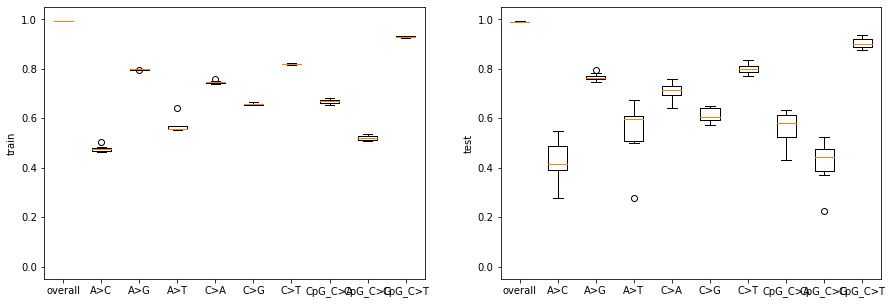

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.472877,0.445810,0.448014,0.419670
A>G,0.795752,0.783709,0.803383,0.791791
A>T,0.564369,0.540939,0.592190,0.570256
C>A,0.743767,0.726774,0.742636,0.725568
C>G,0.654954,0.633343,0.664440,0.643424
C>T,0.818727,0.809874,0.816211,0.807235
CpG_C>A,0.662389,0.620048,0.605201,0.555688
CpG_C>G,0.516532,0.471030,0.466227,0.415989
CpG_C>T,0.928016,0.915936,0.915369,0.901167
overall,0.992096,0.991582,0.991455,0.990900


Shape 1 degree; Sequence context: 4 degree
Class 0, Number of predictors: 381
Class 1, Number of predictors: 475
Class 2, Number of predictors: 344
Class 3, Number of predictors: 317
Class 4, Number of predictors: 255
Class 5, Number of predictors: 183
Class 6, Number of predictors: 144
Class 7, Number of predictors: 110
Class 8, Number of predictors: 161
0.992732489083073
0.9126044346969515


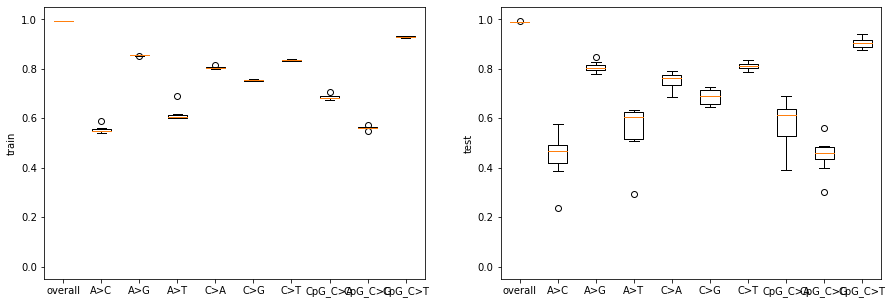

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.547494,0.501073,0.502069,0.450988
A>G,0.852671,0.833339,0.854458,0.835361
A>T,0.608706,0.572821,0.610134,0.574380
C>A,0.801819,0.779007,0.801000,0.778094
C>G,0.749747,0.727086,0.753540,0.731223
C>T,0.833373,0.822815,0.825432,0.814371
CpG_C>A,0.680597,0.628271,0.616246,0.553378
CpG_C>G,0.556518,0.503087,0.494583,0.433690
CpG_C>T,0.929813,0.916704,0.917333,0.901893
overall,0.992732,0.991957,0.992009,0.991156


In [27]:
pred_binned_all = [None, None, 
    np.concatenate((Pred_1d, Pred_sc_2dneibr), axis=1), 
    np.concatenate((Pred_1d, Pred_sc_3dneibr), axis=1), np.concatenate((Pred_1d, Pred_sc_4dneibr), axis=1)
]

for i in range(2, 5):
    dsc = str(i)
    print("Shape 1 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin_neibr = load_L1_indices(
        "data_intermediate/Results_L1_sh1_sc"+dsc+"neibr.joblib", "data_intermediate/Models_L1_sh1_sc"+dsc+"neibr.joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i], Eff, Eff_test, Index_class, Indices_rmL1_bin_neibr, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh1_sc"+dsc+"neibr.joblib")
    dump(CV_L1, "data_out/Results_sh1_sc"+dsc+"neibr.joblib")
    Result.to_csv("data_out/Indtest_sh1_sc"+dsc+"neibr.csv")

#### 2nd order shape + 2nd to 4th degree sequence context (neighbors only)

Shape 1 degree; Sequence context: 2 degree
Class 0, Number of predictors: 611
Class 1, Number of predictors: 701
Class 2, Number of predictors: 293
Class 3, Number of predictors: 727
Class 4, Number of predictors: 601
Class 5, Number of predictors: 479
Class 6, Number of predictors: 145
Class 7, Number of predictors: 88
Class 8, Number of predictors: 196
0.9946617947611877
0.9395942252955375


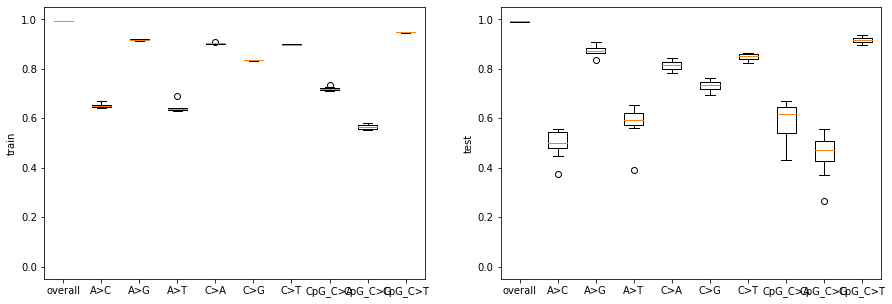

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.642507,0.579813,0.573556,0.498769
A>G,0.915612,0.898182,0.913580,0.895731
A>T,0.636878,0.608894,0.653401,0.626690
C>A,0.899618,0.868484,0.874676,0.835806
C>G,0.829834,0.788429,0.815706,0.770864
C>T,0.895194,0.875826,0.869850,0.845798
CpG_C>A,0.712564,0.665094,0.632356,0.571640
CpG_C>G,0.559440,0.517976,0.496807,0.449447
CpG_C>T,0.947289,0.934796,0.926101,0.908586
overall,0.994662,0.993673,0.993154,0.991886


Shape 1 degree; Sequence context: 3 degree
Class 0, Number of predictors: 711
Class 1, Number of predictors: 654
Class 2, Number of predictors: 451
Class 3, Number of predictors: 418
Class 4, Number of predictors: 926
Class 5, Number of predictors: 424
Class 6, Number of predictors: 64
Class 7, Number of predictors: 114
Class 8, Number of predictors: 130
0.9931227650484108
0.9363012006971858


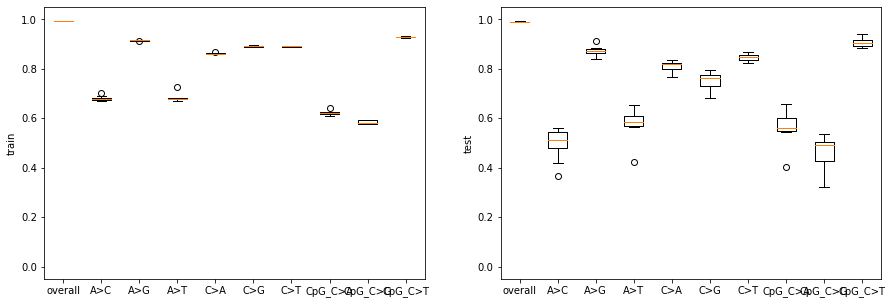

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.669924,0.600573,0.591071,0.505152
A>G,0.912970,0.896429,0.912557,0.895938
A>T,0.676068,0.635976,0.674641,0.634373
C>A,0.859411,0.837261,0.850684,0.827158
C>G,0.884457,0.834577,0.845683,0.779063
C>T,0.888539,0.870685,0.867767,0.846585
CpG_C>A,0.616744,0.591167,0.566166,0.537214
CpG_C>G,0.577464,0.524473,0.506067,0.444121
CpG_C>T,0.927780,0.917266,0.913764,0.901210
overall,0.993123,0.991829,0.992208,0.990742


Shape 1 degree; Sequence context: 4 degree
Class 0, Number of predictors: 507
Class 1, Number of predictors: 698
Class 2, Number of predictors: 134
Class 3, Number of predictors: 422
Class 4, Number of predictors: 393
Class 5, Number of predictors: 456
Class 6, Number of predictors: 105
Class 7, Number of predictors: 94
Class 8, Number of predictors: 173
0.9937173769484154
0.9343961277698566


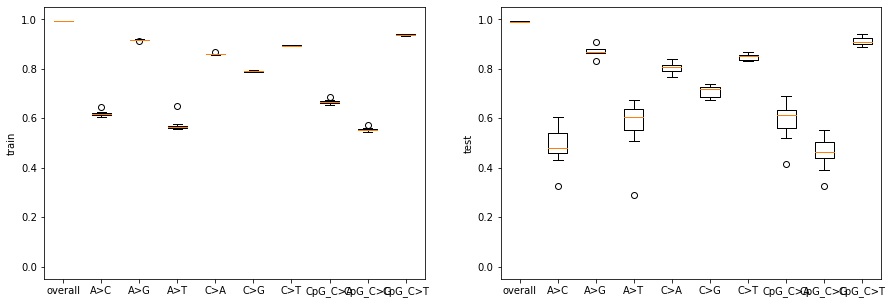

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.611937,0.557102,0.554667,0.491739
A>G,0.914442,0.896863,0.914195,0.896564
A>T,0.570018,0.555472,0.589862,0.575987
C>A,0.856662,0.833828,0.849809,0.825883
C>G,0.785950,0.754537,0.787083,0.755837
C>T,0.891258,0.872296,0.870296,0.847679
CpG_C>A,0.664291,0.625893,0.606178,0.561133
CpG_C>G,0.554134,0.509019,0.489954,0.438345
CpG_C>T,0.936287,0.923320,0.921877,0.905977
overall,0.993717,0.992850,0.992785,0.991788


In [28]:
pred_binned_all = [None, None, 
    np.concatenate((Pred_2dneibr, Pred_sc_2dneibr), axis=1), 
    np.concatenate((Pred_2dneibr, Pred_sc_3dneibr), axis=1), np.concatenate((Pred_2dneibr, Pred_sc_4dneibr), axis=1)
]

for i in range(2, 5):
    dsc = str(i)
    print("Shape 1 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin_neibr = load_L1_indices(
        "data_intermediate/Results_L1_sh2neibr_sc"+dsc+"neibr.joblib", "data_intermediate/Models_L1_sh2neibr_sc"+dsc+"neibr.joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i], Eff, Eff_test, Index_class, Indices_rmL1_bin_neibr, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh2neibr_sc"+dsc+"neibr.joblib")
    dump(CV_L1, "data_out/Results_sh2neibr_sc"+dsc+"neibr.joblib")
    Result.to_csv("data_out/Indtest_sh2neibr_sc"+dsc+"neibr.csv")

## Model comparison

Compare all the models we've had so far:

In [6]:
# This chunk imports the saved results csvs
import_name = ["sc4Varun", "sh1", "sh2neibr", "sc4", "sh1_sc1", "sh1_sc2", "sh1_sc3", "sh1_sc4", 
               "sh2neibr_sc1", "sh2neibr_sc2", "sh2neibr_sc3", "sh2neibr_sc4"]
display_name = ["Aggarwala", "sh1", "sh2neibr", "sc4", "sh1_sc1", "sh1_sc2", "sh1_sc3", "sh1_sc4",
                "sh2neibr_sc1", "sh2neibr_sc2", "sh2neibr_sc3", "sh2neibr_sc4"]

r2_baseline = np.zeros(shape=(10,), dtype=float)
for select in range(9):
    r2_baseline[select] = r2_score(Eff_test[Index_class==select], Eff[Index_class==select])
r2_baseline[9] = r2_score(Eff_test, Eff)

temp_disp_r2train, temp_disp_r2test = pd.DataFrame({'baseline': [1,1,1,1,1,1,1,1,1,1]}), pd.DataFrame({'baseline': r2_baseline})

chnameflag = True
for i in range(len(import_name)):
    import_df = pd.read_csv("data_out/Indtest_" + import_name[i] + ".csv", index_col=0)
    if chnameflag:
        temp_disp_r2train.index, temp_disp_r2test.index = import_df.index, import_df.index
        chnameflag = False
    temp_disp_r2train[display_name[i]] = import_df['train_R2']
    temp_disp_r2test[display_name[i]] = import_df['test_R2']

temp_disp_r2train.to_csv("data_out/Results_compar_bin_train.csv")
temp_disp_r2test.to_csv("data_out/Results_compar_bin_test.csv")

display(temp_disp_r2train)
display(temp_disp_r2test)

,baseline,Aggarwala,sh1,sh2neibr,sc4,sh1_sc1,sh1_sc2,sh1_sc3,sh1_sc4,sh2neibr_sc1,sh2neibr_sc2,sh2neibr_sc3,sh2neibr_sc4
A>C,1,0.580066,0.309833,0.648458,0.653274,0.355153,0.475929,0.572164,0.677261,0.649310,0.628268,0.585846,0.667510
A>G,1,0.915877,0.607715,0.926287,0.937805,0.650088,0.790398,0.892448,0.939826,0.924084,0.917537,0.927085,0.940950
A>T,1,0.566845,0.457312,0.686432,0.606204,0.482227,0.536283,0.596943,0.638922,0.634905,0.635332,0.605188,0.658313
C>A,1,0.839504,0.580184,0.886260,0.907601,0.626443,0.732724,0.858301,0.904129,0.896176,0.893558,0.893377,0.907886
C>G,1,0.810782,0.434593,0.864279,0.867100,0.496007,0.618944,0.757272,0.868681,0.881823,0.843522,0.769698,0.872036
C>T,1,0.870864,0.716030,0.896343,0.915258,0.737985,0.825249,0.886914,0.915523,0.907683,0.901042,0.893491,0.918519
CpG_C>A,1,0.576305,0.591887,0.704173,0.753092,0.628761,0.624187,0.745102,0.754992,0.698754,0.663348,0.729806,0.736823
CpG_C>G,1,0.564764,0.490682,0.604332,0.689576,0.499291,0.531282,0.687284,0.695658,0.557023,0.531491,0.660036,0.676010
CpG_C>T,1,0.930057,0.878316,0.943422,0.963826,0.901078,0.932139,0.955957,0.965521,0.945931,0.943677,0.956606,0.969133
overall,1,0.993163,0.986759,0.994473,0.996177,0.988857,0.992333,0.995168,0.996331,0.994638,0.994360,0.995444,0.996597


,baseline,Aggarwala,sh1,sh2neibr,sc4,sh1_sc1,sh1_sc2,sh1_sc3,sh1_sc4,sh2neibr_sc1,sh2neibr_sc2,sh2neibr_sc3,sh2neibr_sc4
A>C,0.666291,0.580254,0.299829,0.578731,0.581512,0.341260,0.455424,0.532820,0.586199,0.579134,0.568701,0.543395,0.591645
A>G,0.961144,0.919987,0.615280,0.922207,0.929313,0.658699,0.800481,0.893368,0.930415,0.920586,0.915870,0.923850,0.931424
A>T,0.749556,0.605163,0.489098,0.672824,0.591188,0.514254,0.569259,0.603209,0.610173,0.650158,0.653108,0.615676,0.631481
C>A,0.905103,0.840336,0.578703,0.868189,0.876613,0.624594,0.730663,0.845032,0.877821,0.872901,0.872418,0.874875,0.882470
C>G,0.866793,0.819134,0.450661,0.833801,0.841049,0.512664,0.627984,0.758253,0.842336,0.843934,0.824286,0.768128,0.843659
C>T,0.863786,0.875378,0.714377,0.869824,0.877599,0.735687,0.816539,0.871354,0.877930,0.872579,0.874477,0.875983,0.882117
CpG_C>A,0.533678,0.553423,0.559250,0.634640,0.610416,0.578570,0.574152,0.618078,0.609131,0.626211,0.602914,0.614639,0.610559
CpG_C>G,0.416735,0.530545,0.440194,0.517474,0.526647,0.448816,0.490520,0.528789,0.526087,0.480210,0.492968,0.530183,0.523936
CpG_C>T,0.934435,0.932358,0.866938,0.925088,0.931482,0.889348,0.916414,0.930460,0.932331,0.926038,0.926926,0.930121,0.934214
overall,0.993994,0.993584,0.986428,0.993148,0.993644,0.988423,0.991479,0.993304,0.993718,0.993192,0.993213,0.993486,0.993876


How do the neighbor-only models fare against all-interaction models?

In [7]:
import_name = ["sh1", "sh2", "sh2neibr", "sc2", "sc2neibr", "sc3", "sc3neibr", "sc4", "sc4neibr", 
               "sh1_sc2", "sh1_sc2neibr", "sh1_sc3", "sh1_sc3neibr", 
               "sh1_sc4", "sh1_sc4neibr",
               "sh2neibr_sc2", "sh2neibr_sc2neibr", "sh2neibr_sc3", "sh2neibr_sc3neibr", 
               "sh2neibr_sc4", "sh2neibr_sc4neibr"]

r2_baseline = np.zeros(shape=(10,), dtype=float)
for select in range(9):
    r2_baseline[select] = r2_score(Eff_test[Index_class==select], Eff[Index_class==select])
r2_baseline[9] = r2_score(Eff_test, Eff)

temp_disp_r2train, temp_disp_r2test = pd.DataFrame({'baseline': [1,1,1,1,1,1,1,1,1,1]}), pd.DataFrame({'baseline': r2_baseline})

chnameflag = True
for i in range(len(import_name)):
    import_df = pd.read_csv("data_out/Indtest_" + import_name[i] + ".csv", index_col=0)
    if chnameflag:
        temp_disp_r2train.index, temp_disp_r2test.index = import_df.index, import_df.index
        chnameflag = False
    temp_disp_r2train[import_name[i]] = import_df['train_R2']
    temp_disp_r2test[import_name[i]] = import_df['test_R2']

temp_disp_r2train.to_csv("data_out/Results_compar_neighbor_train.csv")
temp_disp_r2test.to_csv("data_out/Results_compar_neighbor_test.csv")

display(temp_disp_r2train)
display(temp_disp_r2test)

,baseline,sh1,sh2,sh2neibr,sc2,sc2neibr,sc3,sc3neibr,sc4,sc4neibr,...,sh1_sc3,sh1_sc3neibr,sh1_sc4,sh1_sc4neibr,sh2neibr_sc2,sh2neibr_sc2neibr,sh2neibr_sc3,sh2neibr_sc3neibr,sh2neibr_sc4,sh2neibr_sc4neibr
A>C,1,0.309833,0.597699,0.648458,0.426719,0.334714,0.568934,0.427025,0.653274,0.482667,...,0.572164,0.472877,0.677261,0.547494,0.628268,0.642507,0.585846,0.669924,0.667510,0.611937
A>G,1,0.607715,0.922733,0.926287,0.746094,0.640797,0.893989,0.729320,0.937805,0.743922,...,0.892448,0.795752,0.939826,0.852671,0.917537,0.915612,0.927085,0.912970,0.940950,0.914442
A>T,1,0.457312,0.670343,0.686432,0.510145,0.459333,0.592268,0.520594,0.606204,0.562553,...,0.596943,0.564369,0.638922,0.608706,0.635332,0.636878,0.605188,0.676068,0.658313,0.570018
C>A,1,0.580184,0.910672,0.886260,0.661170,0.597710,0.825176,0.696137,0.907601,0.760988,...,0.858301,0.743767,0.904129,0.801819,0.893558,0.899618,0.893377,0.859411,0.907886,0.856662
C>G,1,0.434593,0.867692,0.864279,0.557901,0.457661,0.755344,0.604991,0.867100,0.711299,...,0.757272,0.654954,0.868681,0.749747,0.843522,0.829834,0.769698,0.884457,0.872036,0.785950
C>T,1,0.716030,0.898180,0.896343,0.791988,0.715998,0.884995,0.805945,0.915258,0.826944,...,0.886914,0.818727,0.915523,0.833373,0.901042,0.895194,0.893491,0.888539,0.918519,0.891258
CpG_C>A,1,0.591887,0.695228,0.704173,0.632004,0.557412,0.738058,0.615573,0.753092,0.656902,...,0.745102,0.662389,0.754992,0.680597,0.663348,0.712564,0.729806,0.616744,0.736823,0.664291
CpG_C>G,1,0.490682,0.620062,0.604332,0.521883,0.425060,0.656114,0.496727,0.689576,0.548841,...,0.687284,0.516532,0.695658,0.556518,0.531491,0.559440,0.660036,0.577464,0.676010,0.554134
CpG_C>T,1,0.878316,0.934675,0.943422,0.922001,0.862377,0.952884,0.899792,0.963826,0.923577,...,0.955957,0.928016,0.965521,0.929813,0.943677,0.947289,0.956606,0.927780,0.969133,0.936287
overall,1,0.986759,0.993805,0.994473,0.991169,0.985732,0.994898,0.989442,0.996177,0.991510,...,0.995168,0.992096,0.996331,0.992732,0.994360,0.994662,0.995444,0.993123,0.996597,0.993717


,baseline,sh1,sh2,sh2neibr,sc2,sc2neibr,sc3,sc3neibr,sc4,sc4neibr,...,sh1_sc3,sh1_sc3neibr,sh1_sc4,sh1_sc4neibr,sh2neibr_sc2,sh2neibr_sc2neibr,sh2neibr_sc3,sh2neibr_sc3neibr,sh2neibr_sc4,sh2neibr_sc4neibr
A>C,0.666291,0.299829,0.538520,0.578731,0.413254,0.326221,0.527979,0.407497,0.581512,0.446439,...,0.532820,0.448014,0.586199,0.502069,0.568701,0.573556,0.543395,0.591071,0.591645,0.554667
A>G,0.961144,0.615280,0.920418,0.922207,0.755598,0.649499,0.894514,0.739321,0.929313,0.750784,...,0.893368,0.803383,0.930415,0.854458,0.915870,0.913580,0.923850,0.912557,0.931424,0.914195
A>T,0.749556,0.489098,0.672069,0.672824,0.543133,0.495868,0.596595,0.550692,0.591188,0.572760,...,0.603209,0.592190,0.610173,0.610134,0.653108,0.653401,0.615676,0.674641,0.631481,0.589862
C>A,0.905103,0.578703,0.883743,0.868189,0.666181,0.607692,0.816076,0.701824,0.876613,0.765171,...,0.845032,0.742636,0.877821,0.801000,0.872418,0.874676,0.874875,0.850684,0.882470,0.849809
C>G,0.866793,0.450661,0.836551,0.833801,0.571532,0.475512,0.757107,0.618433,0.841049,0.717907,...,0.758253,0.664440,0.842336,0.753540,0.824286,0.815706,0.768128,0.845683,0.843659,0.787083
C>T,0.863786,0.714377,0.870506,0.869824,0.784710,0.718508,0.869194,0.801224,0.877599,0.818741,...,0.871354,0.816211,0.877930,0.825432,0.874477,0.869850,0.875983,0.867767,0.882117,0.870296
CpG_C>A,0.533678,0.559250,0.631292,0.634640,0.587290,0.526544,0.607113,0.571355,0.610416,0.594880,...,0.618078,0.605201,0.609131,0.616246,0.602914,0.632356,0.614639,0.566166,0.610559,0.606178
CpG_C>G,0.416735,0.440194,0.532281,0.517474,0.484295,0.396678,0.535023,0.457568,0.526647,0.497089,...,0.528789,0.466227,0.526087,0.494583,0.492968,0.496807,0.530183,0.506067,0.523936,0.489954
CpG_C>T,0.934435,0.866938,0.918123,0.925088,0.907726,0.850136,0.927502,0.888878,0.931482,0.912177,...,0.930460,0.915369,0.932331,0.917333,0.926926,0.926101,0.930121,0.913764,0.934214,0.921877
overall,0.993994,0.986428,0.992641,0.993148,0.990474,0.985396,0.993065,0.989051,0.993644,0.990966,...,0.993304,0.991455,0.993718,0.992009,0.993213,0.993154,0.993486,0.992208,0.993876,0.992785


### Combine different model settings for each substitution class

For each subclass, use the model that gives the best predictive power.

In [6]:
model_info = ['sh2neibr', 'sh2neibr_sc1', 'sh2neibr_sc3', 'sh2neibr_sc4']
model_use = [3, 3, 0, 1, 1, 3, 0, 3, 3]

all_models = [load("data_intermediate/Models_L1_" + str(item) + ".joblib") for item in model_info]
results = [load("data_intermediate/Results_L1_" + str(item) + ".joblib") for item in model_info]
pred_list = [Pred_2dneibr, 
             np.concatenate((Pred_2dneibr, Pred_sc_1d), axis=1),
             np.concatenate((Pred_2dneibr, Pred_sc_3d), axis=1),
             np.concatenate((Pred_2dneibr, Pred_sc_4d), axis=1)]

Indices_rmL1_binpred, alpha_list = [], []
for select in range(9):
    min_loc = np.argmin(
        [np.mean(results[model_use[select]][select][key]['test_mse']) for key in results[model_use[select]][select].keys()]
    )
    alpha_list.append( list(results[model_use[select]][select].keys())[min_loc] )
    temp_pred = pred_list[model_use[select]][Index_class==select]
    Indices_rmL1_binpred.append( all_models[model_use[select]][select][alpha_list[select]].coef_ != 0 )
    print(np.sum(Indices_rmL1_binpred[select]))

Model_bin_L1_final = linreg_subclass_binpred(pred_used=model_use, model_indices=Indices_rmL1_binpred, lin_or_log=[0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                             n_jobs=4)
Model_bin_L1_final.fit(pred_list, Eff, Index_class)
tmp_out = Model_bin_L1_final.predict(pred_list, Index_class)
print(r2_score(Eff, tmp_out))   # This is the R^2 value
print(r2_score(Eff[Index_class!=8], tmp_out[Index_class!=8]))   # This is the R^2 value for non CpG C>T

# Save model
dump(Model_bin_L1_final, "data_out/Model_final.joblib")

/home/zianl/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Lasso from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/zianl/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


373
643
501
709
896
600
123
233
527
0.9965776478458839
0.9516893762394685


['data_out/Model_final.joblib']

In [7]:
p_length = [np.sum(Indices_rmL1_binpred[i]) for i in range(9)]
Result_bin_L1_final = standard_traintestresult_df(tmp_out, Eff, Eff_test, Index_class, p=p_length, display='df')
display(Result_bin_L1_final)
Result_bin_L1_final.to_csv("data_out/Indtest_final.csv")

# Save data
temp_df_save = pd.DataFrame({'Predicted': tmp_out,'Train': Eff, 'Test': Eff_test, 'Subclass': Index_class})
temp_df_save.to_csv("data_out/Model_final_plottingresults.csv", index=None)

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.667510,0.634189,0.591645,0.550722
A>G,0.940950,0.929951,0.931424,0.918650
A>T,0.686432,0.642721,0.672824,0.627216
C>A,0.896176,0.865011,0.872901,0.834750
C>G,0.881823,0.833139,0.843934,0.779641
C>T,0.918519,0.898734,0.882117,0.853493
CpG_C>A,0.704173,0.663743,0.634640,0.584708
CpG_C>G,0.677563,0.582465,0.526694,0.387099
CpG_C>T,0.969133,0.936337,0.934217,0.864323
overall,0.996578,0.995788,0.993897,0.992490


Plot the training and testing scatterplots, return them for manuscript:

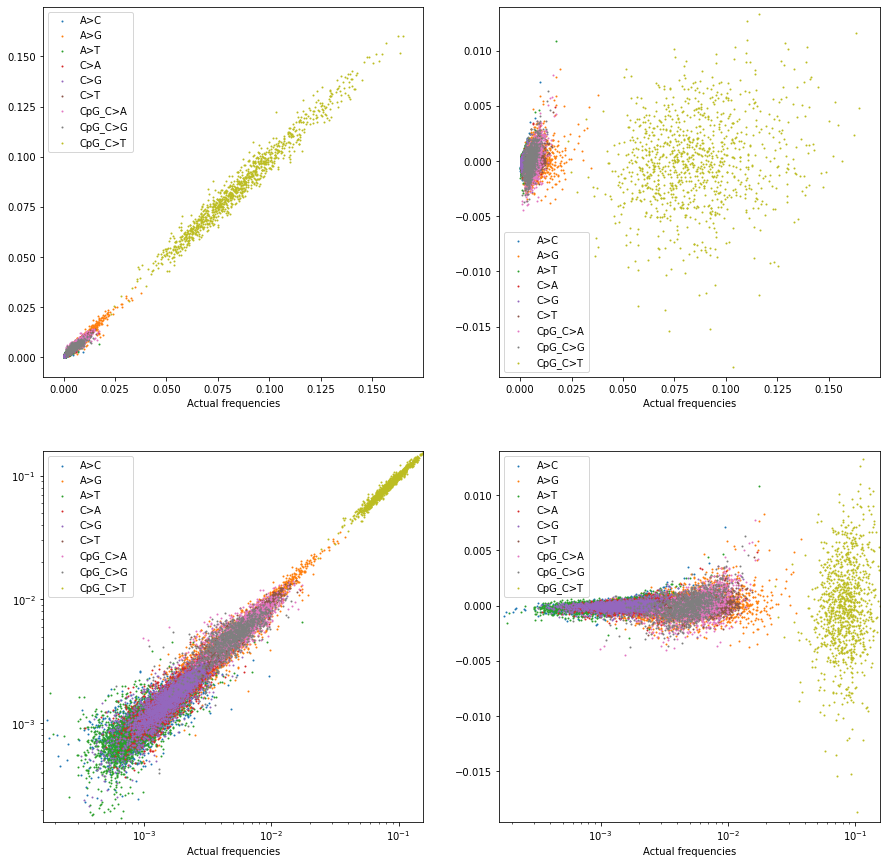

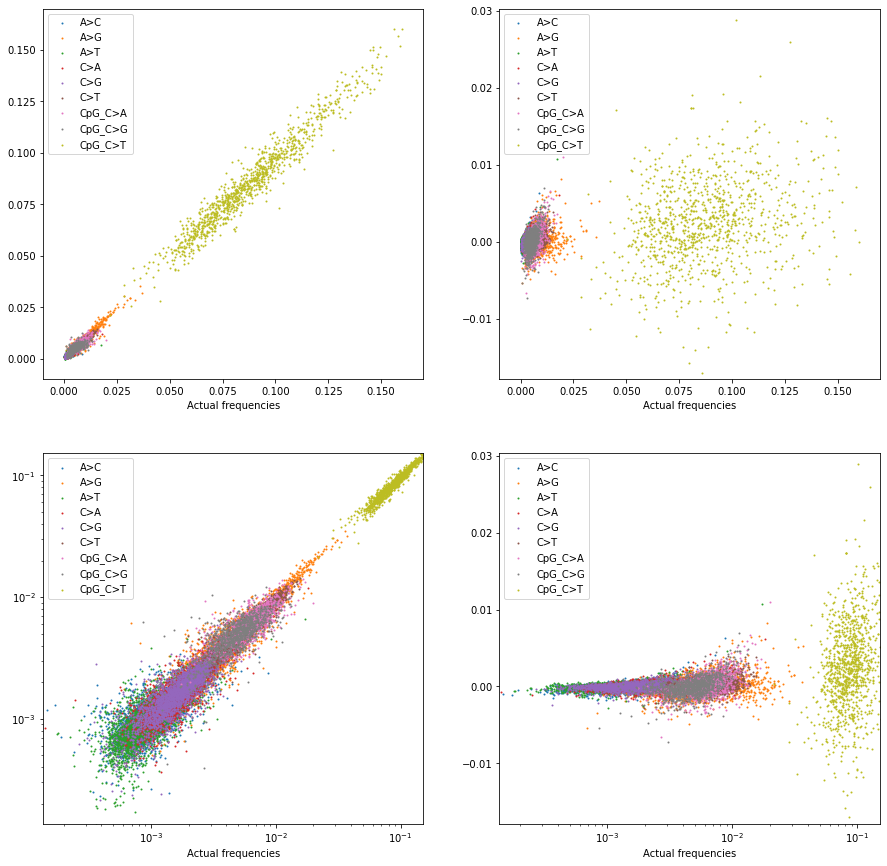

In [8]:
plot_scatter_residual(tmp_out, Eff, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_sup4_model_final_train.tiff")
plot_scatter_residual(tmp_out, Eff_test, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_fig2b_model_final_test.tiff")

Show plot difference between this, Varun's model, and the 2nd order shape model:

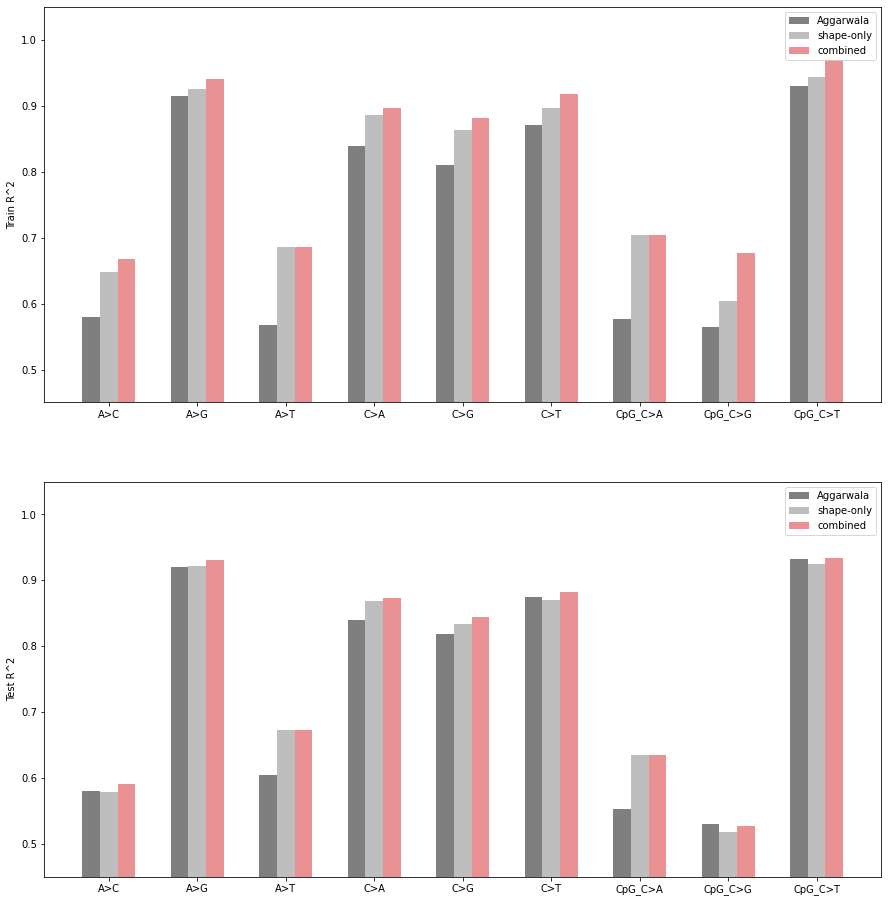

,Aggarwala,sc4,Liu
A>C,0.580254,0.578731,0.591645
A>G,0.919987,0.922207,0.931424
A>T,0.605163,0.672824,0.672824
C>A,0.840336,0.868189,0.872901
C>G,0.819134,0.833801,0.843934
C>T,0.875378,0.869824,0.882117
CpG_C>A,0.553423,0.634640,0.634640
CpG_C>G,0.530545,0.517474,0.526694
CpG_C>T,0.932358,0.925088,0.934217


In [ ]:
temp_fig = plt.figure(figsize=[15, 16])
legends = ['Aggarwala', 'shape-only', 'combined']
# The six columns are Aggarwala train, Aggarwala test, sc4 train, sc4 test, final model train, final model test
temp_plt = [
    pd.read_csv("data_out/Results_compar_bin_train.csv", index_col=0)['Aggarwala'],
    pd.read_csv("data_out/Results_compar_bin_test.csv", index_col=0)['Aggarwala'],
    pd.read_csv("data_out/Results_compar_bin_train.csv", index_col=0)['sh2neibr'],
    pd.read_csv("data_out/Results_compar_bin_test.csv", index_col=0)['sh2neibr'],
    np.array(Result_bin_L1_final['train_R2']), np.array(Result_bin_L1_final['test_R2'])
]
plt.subplot(211)
plt.bar(np.arange(1, 10)-0.2, temp_plt[0][0:9], width=0.2, alpha=0.5, color='k')
plt.bar(np.arange(1, 10), temp_plt[2][0:9], width=0.2, alpha=0.5, color='tab:gray')
plt.bar(np.arange(1, 10)+0.2, temp_plt[4][0:9], width=0.2, alpha=0.5, color='tab:red')
plt.legend(legends, loc='upper right')
plt.xticks(np.arange(1, 10), Index_class_name)
plt.ylim(0.45, 1.05)
plt.ylabel("Train R^2")

plt.subplot(212)
plt.bar(np.arange(1, 10)-0.2, temp_plt[1][0:9], width=0.2, alpha=0.5, color='k')
plt.bar(np.arange(1, 10), temp_plt[3][0:9], width=0.2, alpha=0.5, color='tab:gray')
plt.bar(np.arange(1, 10)+0.2, temp_plt[5][0:9], width=0.2, alpha=0.5, color='tab:red')
plt.legend(legends, loc='upper right')
plt.xticks(np.arange(1, 10), Index_class_name)
plt.ylim(0.45, 1.05)
plt.ylabel("Test R^2")
plt.show()
temp_fig.savefig("manuscript/figures/pltout_fig2a_finalmodelcompar.pdf", dpi=300)

pd.DataFrame(
    {'Aggarwala': temp_plt[1][0:9], 'sc4': temp_plt[3][0:9], 'Liu': temp_plt[5][0:9]}
)

We can get the train/test results as above. 

#### Save convenient 7-mer prediction results

For ease of access, make predictions for all 7-mers:

In [15]:
temp_seqs = [item.split(",")[0] for item in 
             pd.read_csv("data_input/ben_data_7mer_bayesian_test_training_AFR_10", sep='\t', header=2).trans]
temp_frqs = Model_bin_L1_final.predict(pred_list, Index_class)
temp_class = [Index_class_name[item] for item in Index_class]

df_out = pd.DataFrame({
    "7mer": temp_seqs, "mutclass": temp_class, 
    "frq": temp_frqs
})

df_out.to_csv("data_out/table_7merpredictions_bestmodel.csv")
display(df_out)

,7mer,mutclass,frq
0,TTAACCA,A>C,0.001101
1,AAGAATA,A>C,0.001098
2,GGAAGCT,A>C,0.000895
3,TAAACGT,A>C,0.000934
4,CAAAAGG,A>C,0.000886
...,...,...,...
24571,CACCGTC,CpG_C>T,0.068589
24572,GTTCGCC,CpG_C>T,0.075295
24573,CTACCGG,C>T,0.006828
24574,CATCATA,C>T,0.004690


#### Cross-mutation class analysis?

How does the best-performing model performs across mutation classes?

In [16]:
model_info = ['sh2neibr', 'sh2neibr_sc1', 'sh2neibr_sc3', 'sh2neibr_sc4']
model_use = [3, 3, 0, 1, 1, 3, 2, 3, 3]

all_models = [load("data_intermediate/Models_L1_" + str(item) + ".joblib") for item in model_info]
results = [load("data_intermediate/Results_L1_" + str(item) + ".joblib") for item in model_info]
pred_list = [Pred_2dneibr, 
             np.concatenate((Pred_2dneibr, Pred_sc_1d), axis=1),
             np.concatenate((Pred_2dneibr, Pred_sc_3d), axis=1),
             np.concatenate((Pred_2dneibr, Pred_sc_4d), axis=1)]

Indices_rmL1_binpred, alpha_list = [], []
for select in range(9):
    min_loc = np.argmin(
        [np.mean(results[model_use[select]][select][key]['test_mse']) for key in results[model_use[select]][select].keys()]
    )
    alpha_list.append( list(results[model_use[select]][select].keys())[min_loc] )
    temp_pred = pred_list[model_use[select]][Index_class==select]
    Indices_rmL1_binpred.append( all_models[model_use[select]][select][alpha_list[select]].coef_ != 0 )

Model_bin_L1_final = linreg_subclass_binpred(pred_used=model_use, model_indices=Indices_rmL1_binpred, lin_or_log=[0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                             n_jobs=4)
Model_bin_L1_final.fit(pred_list, Eff, Index_class)

/home/zianl/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Lasso from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/zianl/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [17]:
# Make results
Results_predict_class = dict()
for select in range(9):
    Results_predict_class[select] = Model_bin_L1_final.predict(pred_list, np.full(shape=np.shape(Index_class), fill_value=select))
# Comparison results
results_allmodel = Model_bin_L1_final.predict(pred_list, Index_class)

For sanity check, see if results from our per-class results generation is the same as what we would get from using all models. The lists of equal values should be 4096*3, 3072*3, and 1024*3.

In [16]:
for select in range(9):
    print(np.sum( Results_predict_class[select] == results_allmodel ))

4096
4096
4096
3072
3072
3072
1024
1024
424


Something is wrong with class 8 (CpG C>T)?

In [17]:
print(Results_predict_class[8][Index_class==8])
print(results_allmodel[Index_class==8])
print(r2_score(Results_predict_class[8][Index_class==8], results_allmodel[Index_class==8]))

[0.1089555  0.09204295 0.10995831 ... 0.07887974 0.0685853  0.07529643]
[0.1089555  0.09204307 0.10995867 ... 0.07888009 0.0685853  0.0752969 ]
0.9999999997642989


Looks like there are some very minute floating-point changes for some reason. The R^2 value is high enough to ignore the differences.

Make the plot and R^2 table:

In [18]:
plotting_trio = np.empty(shape=(9, 9, 3), dtype=object)

for i in range(9):
    for j in range(9):
        plotting_trio[i, j, 0] = Results_predict_class[i][Index_class == j]
        plotting_trio[i, j, 1] = Eff[Index_class == j]
        plotting_trio[i, j, 2] = Eff_test[Index_class == j]

In [19]:
# Make the R^2 comparison tables
cross_model_r2table_train, cross_model_r2table_test = np.empty(shape=(9, 9), dtype=float), np.empty(shape=(9, 9), dtype=float)
for i in range(9):
    for j in range(9):
        cross_model_r2table_train[i, j] = r2_score(plotting_trio[i, j, 1], plotting_trio[i, j, 0])
        cross_model_r2table_test[i, j] = r2_score(plotting_trio[i, j, 2], plotting_trio[i, j, 0])
# Trim off below 0 values
cross_model_r2table_train[cross_model_r2table_train < 0] = 0
cross_model_r2table_test[cross_model_r2table_test < 0] = 0
# Beautify and formatting
cross_model_r2table_train = pd.DataFrame(cross_model_r2table_train)
cross_model_r2table_test = pd.DataFrame(cross_model_r2table_test)
tmp_index, tmp_col = ["Model_class_"+str(select) for select in range(9)], ["Data_class_"+str(select) for select in range(9)]
cross_model_r2table_train.index, cross_model_r2table_test.index = tmp_index, tmp_index
cross_model_r2table_train.columns, cross_model_r2table_test.columns = tmp_col, tmp_col
# Add 10th column as "reference":
cross_model_r2table_train['reference'] = [r2_score( plotting_trio[select, select, 1], results_allmodel[Index_class==select] ) for select in range(9)]
cross_model_r2table_test['reference'] = [r2_score( plotting_trio[select, select, 2], results_allmodel[Index_class==select] ) for select in range(9)]

display(cross_model_r2table_train)
display(cross_model_r2table_test)
# Save tables
with pd.ExcelWriter(path="data_out/Results_crossmodeltest.xlsx", mode='w') as savexcel:
    cross_model_r2table_train.to_excel(savexcel, sheet_name='train')
    cross_model_r2table_test.to_excel(savexcel, sheet_name='test')

,Data_class_0,Data_class_1,Data_class_2,Data_class_3,Data_class_4,Data_class_5,Data_class_6,Data_class_7,Data_class_8,reference
Model_class_0,0.66751,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.667510
Model_class_1,0.00000,0.94095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.940950
Model_class_2,0.00000,0.00000,0.686432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.686432
Model_class_3,0.00000,0.00000,0.000000,0.896176,0.000000,0.000000,0.000000,0.000000,0.000000,0.896176
Model_class_4,0.00000,0.00000,0.000000,0.000000,0.881823,0.000000,0.000000,0.000000,0.000000,0.881823
Model_class_5,0.00000,0.00000,0.000000,0.000000,0.000000,0.918519,0.000000,0.000000,0.000000,0.918519
Model_class_6,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.729804,0.000000,0.000000,0.729804
Model_class_7,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.677563,0.000000,0.677563
Model_class_8,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.969133,0.969133


,Data_class_0,Data_class_1,Data_class_2,Data_class_3,Data_class_4,Data_class_5,Data_class_6,Data_class_7,Data_class_8,reference
Model_class_0,0.591645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.591645
Model_class_1,0.000000,0.931424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.931424
Model_class_2,0.000000,0.000000,0.672824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.672824
Model_class_3,0.000000,0.000000,0.000000,0.872901,0.000000,0.000000,0.000000,0.000000,0.000000,0.872901
Model_class_4,0.000000,0.000000,0.000000,0.000000,0.843934,0.000000,0.000000,0.000000,0.000000,0.843934
Model_class_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.882117,0.000000,0.000000,0.000000,0.882117
Model_class_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.614752,0.000000,0.000000,0.614752
Model_class_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.526694,0.000000,0.526694
Model_class_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.934217,0.934217


As we can see, the models tend to perform poorly in other mutation classes.

This concludes the model building notebook. Next, proceed to model analysis/interpretation.